# Preamble

In [ ]:
import os
import os.path
import sys, importlib

import logging
import warnings
import time
from copy import deepcopy
from typing import Tuple

import numpy as np
import xarray as xr
import pandas as pd

import math
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.stats import ttest_ind

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

import statannot
from statannotations.Annotator import Annotator


import utils
from restore_data import recover_data
importlib.reload(sys.modules['restore_data'])
importlib.reload(sys.modules['utils'])



logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s :: %(levelname)s :: %(message)s')
log = logging.getLogger("DataImport")
log.setLevel(logging.DEBUG)



from IPython.display import set_matplotlib_formats
%matplotlib inline

## Style

In [ ]:
plt.style.context('seaborn-paper')
# plt.style.use('seaborn-notebook')
# plt.style.use('seaborn-poster')
# plt.style.use('seaborn-talk')
set_matplotlib_formats('svg')
plt.rcParams.update(plt.rcParamsDefault)


linewidth = 0.25
titlesize = 'medium'
labelsize = 'small'
ticksize = 'x-small'

markersize = 10
scattersize = 5

palette_stages='gist_heat'

plt.rcParams.update({
    'figure.figsize': [5.9/2, 5.9/2 * 2/3],

    'text.usetex': False,
    'font.size': 10,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Helvetica',

    'figure.titlesize': titlesize,
    'legend.title_fontsize': labelsize,
    'legend.fontsize': ticksize,
    'axes.labelsize': labelsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize,
    'ytick.labelsize': ticksize,

    'figure.autolayout': False,

    'axes.linewidth': linewidth,
    'xtick.major.width': linewidth,
    'xtick.minor.width': 0.8*linewidth,
    'ytick.major.width': linewidth,
    'ytick.minor.width': 0.8*linewidth,
    'grid.linewidth': linewidth,

    'patch.linewidth': linewidth,

    'lines.markersize': scattersize
})

    

from IPython.display import set_matplotlib_formats
%matplotlib inline

In [ ]:
basepath = os.path.dirname('')
basepath = os.path.abspath(os.path.join(basepath, ".."))
data_basedir = "data"
rel_paths=[
    'Live_imaging/Control/E10_Control_1_2',
    'Live_imaging/Control/E10_Control_2_1',
    'Live_imaging/Control/E10_Control_3',
    'Live_imaging/Control/E10_Control_99',
    'Live_imaging/ML7/E10_ML7_1',
    'Live_imaging/ML7/E10_ML7_2_1',
    'Live_imaging/PTX/E10_PTX_1_1',
    'Live_imaging/PTX/E10_PTX_2_1',
]
data_path = "102_treated_data"
load_file_prefix='summary'
save_file_prefix='summary_live_imaging'

min_tracking_period = 5 # number of frames

In [ ]:
figure_path = 'analysis/1_figures'
figure_path = os.path.abspath(os.path.join(basepath, figure_path))

## Import data

In [ ]:
paths = []
for p in rel_paths:
    paths.append(os.path.join(basepath, data_basedir, p, data_path))
cells, bonds = recover_data(paths=paths, save_file_prefix=load_file_prefix)
cells = cells.loc[~cells['is_border_cell']]

HC = cells.loc[cells['is_HC']]
SC = cells.loc[~cells['is_HC']]

In [ ]:
bonds['center_x_bonds'] = (bonds['vx_1_x'] + bonds['vx_2_x']) / 2
bonds['center_y_bonds'] = (bonds['vx_1_y'] + bonds['vx_2_y']) / 2
bonds['length_shortest'] = ((bonds['vx_2_x'] - bonds['vx_1_x'])**2 + (bonds['vx_2_y'] - bonds['vx_1_y'])**2)**0.5
bonds['excess_length'] = bonds['bond_length_in_px'] - bonds['length_shortest']

## Generate cilia data from cells

In [ ]:
cilia = pd.DataFrame()

cilia['global_id'] = cells['global_id_cells']
cilia['filename'] = cells['filename']
cilia['file_id'] = cells['file_id']
cilia['filepath'] = cells['filepath']
cilia['X'] = cells['center_x_cells'] + cells['cilium_DX']
cilia['Y'] = cells['center_y_cells'] + cells['cilium_DY']

In [ ]:
def closest_cilium(bond, *, cilia):
    """Assign to a cell the cilium that is the closest in space

    Return:
        - global id of cilium
        - distance of cilium to cell center in units of cell radius
        - X position of cilium
        - Y position of cilium
        - Number of cilia that have distance rho < 1 to cell center

    """
    _cilia = cilia.loc[cilia['file_id'] == bond['file_id']].reset_index()
    if _cilia.empty or bond['type'] == 'border_plus_one':
        cilium = pd.Series(data=None, index=_cilia.columns, dtype=object)
        cilium['rho'] = np.nan
        return cilium

    r = (  (_cilia['X'] - bond['center_x_bonds'])**2
         + (_cilia['Y'] - bond['center_y_bonds'])**2)**0.5

    id = r.loc[r == r.min()].index[0]
    cilium = _cilia.iloc[id]
    cilium['rho'] = r.iloc[id]

    return cilium

Experiment = 'Control'
sample_id = 2
frame = cells.loc[cells['Experiment'] == Experiment]
frame = frame.loc[frame['sample_id'] == sample_id]
frame_bonds = bonds.loc[bonds['Experiment'] == Experiment]
frame_bonds = frame_bonds.loc[frame_bonds['sample_id'] == sample_id]

__cilia = cilia.loc[~np.isnan(cilia['X'])]
assigned_cilia = bonds.apply(closest_cilium, axis=1, cilia=__cilia)

In [ ]:
bonds['cilium_X'] = assigned_cilia['X']
bonds['cilium_Y'] = assigned_cilia['Y']
bonds['cilium_DX'] = bonds['center_x_bonds'] - bonds['cilium_X']
bonds['cilium_DY'] = bonds['center_y_bonds'] - bonds['cilium_Y']
bonds['cilium_rho'] = assigned_cilia['rho']

In [ ]:
bonds['cilium_angular_distance'] = np.nan

for id, cell in cells.loc[~np.isnan(cells['cilium_X'])].iterrows():
    if not cell['is_HC']:
        continue

    cx = cell['center_x_cells']
    cy = cell['center_y_cells']

    rho = (cell['area_cells']/ math.pi)**0.5
    px = cell['cilium_rho_corrected'] * np.cos(cell['cilium_phi_corrected'])
    py = cell['cilium_rho_corrected'] * np.sin(cell['cilium_phi_corrected'])

    # HS bonds
    for bond_id in cell['global_id_bonds']:
        bond = bonds.loc[bonds['global_id_bonds']==bond_id].iloc[0]

        bx = cx - bond['center_x_bonds']
        by = cy - bond['center_y_bonds']

        angle = np.arccos((px * bx + py * by) / ((bx**2+by**2)**0.5 * (px**2+py**2)**0.5))

        bonds.loc[bonds['global_id_bonds']==bond_id, 'cilium_angular_distance'] = angle

    # SS bonds
    cnt = 0
    for vx, vy in zip(cell['vx_coords_x_cells'], cell['vx_coords_y_cells']):
        __bonds = bonds.loc[
            (bonds['filename']==cell['filename']) & 
            (bonds['type']=='SS')
        ]
        if __bonds.empty:
            raise
        b = __bonds.loc[
            ((__bonds['vx_1_x']==vx) | (__bonds['vx_2_x']==vx)) &
            ((__bonds['vx_1_y']==vy) | (__bonds['vx_2_y']==vy))
        ]
        if b.empty:
            continue
        if len(b) > 1:
            print("More than one SS bond found: {}".format(b))
            continue
        b = b.iloc[0]
        cnt += 1

        bx = cx - vx
        by = cy - vy

        angle = np.arccos((px * bx + py * by) / ((bx**2+by**2)**0.5 * (px**2+py**2)**0.5))
        
        if not np.isnan(b['cilium_angular_distance']):
            angle = max(angle, b['cilium_angular_distance'])

        bonds.loc[bonds['global_id_bonds']==b['global_id_bonds'], 'cilium_angular_distance'] = angle
    if cnt == 0:
        print(cell[['filename', 'global_id_cells']])

print(bonds.groupby(by='filename').apply(lambda bonds: bonds['cilium_angular_distance'].count()).to_string())

## Temporal averages (tracked bonds and cells)

In [ ]:
_bonds = bonds.loc[bonds['type'] != 'border_plus_one']
_bonds = _bonds.loc[_bonds['type'] != 'border']
_bonds = _bonds.loc[_bonds['type'] != 'HH']

tracked_bonds = pd.DataFrame(
    _bonds.groupby(by='global_track_id_bonds').apply(
        lambda tracked_bond: tracked_bond['type'].unique()[0]),
    columns=['type']
)


tracked_bonds['tracked_frames'] = bonds.groupby(by='global_track_id_bonds').apply(
    lambda tracked_bond: tracked_bond['time'].count()
)
tracked_bonds['tracked_time'] = _bonds.groupby(by='global_track_id_bonds').apply(
    lambda tracked_bond: tracked_bond['time'].max() - tracked_bond['time'].min()
)


tracked_bonds['Experiment'] = _bonds.groupby(by='global_track_id_bonds').apply(
    lambda tracked_bond: tracked_bond['Experiment'].unique()[0]
)
tracked_bonds['position'] = _bonds.groupby(by='global_track_id_bonds').apply(
    lambda tracked_bond: tracked_bond['filename'].unique()[0].split('00')[0][:-5]
)
tracked_bonds['filepath'] = _bonds.groupby(by='global_track_id_bonds').apply(
    lambda tracked_bond: tracked_bond['filepath'].unique()[0]
)


tracked_bonds['bond_length_mean'] = _bonds.groupby(by='global_track_id_bonds')['bond_length_in_px'].mean()
tracked_bonds['bond_excess_length_mean'] = _bonds.groupby(by='global_track_id_bonds')['excess_length'].mean()

tracked_bonds['bond_length_stddev_norm'] = _bonds.groupby(by='global_track_id_bonds')['bond_length_in_px'].std() / tracked_bonds['bond_length_mean']
tracked_bonds['bond_excess_length_stddev_norm'] = _bonds.groupby(by='global_track_id_bonds')['excess_length'].std() / tracked_bonds['bond_excess_length_mean']
tracked_bonds['bond_excess_length_stddev'] = _bonds.groupby(by='global_track_id_bonds')['excess_length'].std()

tracked_bonds['bond_length_variance_norm'] = _bonds.groupby(by='global_track_id_bonds')['bond_length_in_px'].var() / tracked_bonds['bond_length_mean']

def running_stddev_norm(tracked_bond):
    tb_length = tracked_bond['bond_length_in_px'].rolling(10)
    return (tb_length.std() / tb_length.mean()).mean()

tracked_bonds['bond_length_running_stddev_norm'] = _bonds.groupby(by='global_track_id_bonds').apply(
    running_stddev_norm
)


tracked_bonds['bond_orientation_mean'] = _bonds.groupby(by='global_track_id_bonds')['bond_orientation'].mean()

tracked_bonds['bond_orientation_stddev'] = _bonds.groupby(by='global_track_id_bonds')['bond_orientation'].std()

def classify_orientation__by_3(tracked_bond):
    orientation = tracked_bond['bond_orientation_mean']
    
    if orientation < math.pi / 6:
        return 'horizontal'
    elif orientation < 2 * math.pi / 6:
        return 'diagonal'
    elif orientation < 4 * math.pi / 6:
        return 'vertical'
    elif orientation < 5 * math.pi / 6:
        return 'diagonal'
    else:
        return 'horizontal'
        
def classify_orientation__by_2(tracked_bond):
    orientation = tracked_bond['bond_orientation_mean']

    if orientation < math.pi / 2:
        return 'horizontal'
    # elif orientation < 3 * math.pi / 4:
    else:
        return 'vertical'
    # else:
    #     return 'horizontal'


tracked_bonds['bond_orientation_class'] = tracked_bonds.apply(
    classify_orientation__by_3,
    axis=1
)
tracked_bonds['bond_orientation_class__by_2'] = tracked_bonds.apply(
    classify_orientation__by_2,
    axis=1
)

# Classify bonds
tracked_bonds.loc[tracked_bonds['type'] == 'HS', 'class__'] = 'HS'
tracked_bonds.loc[tracked_bonds['type'] == 'SS', 'class__'] = tracked_bonds['bond_orientation_class']
tracked_bonds.loc[tracked_bonds['class__'] == 'diagonal', 'class__'] = 'SS_other'
tracked_bonds.loc[tracked_bonds['class__'] == 'vertical', 'class__'] = 'SS_other'

tracked_bonds['class'] = tracked_bonds['class__']
tracked_bonds.loc[tracked_bonds['class'] == 'SS_horizontal', 'class'] = 'SS || P-D'
tracked_bonds.loc[tracked_bonds['class'] == 'SS_other', 'class'] = 'SS non P-D'


# polarity
tracked_bonds['cilium_rho__mean'] = _bonds.groupby(by='global_track_id_bonds')['cilium_rho'].mean()
tracked_bonds['cilium_rho__max'] = _bonds.groupby(by='global_track_id_bonds')['cilium_rho'].max()
tracked_bonds['cilium_rho__min'] = _bonds.groupby(by='global_track_id_bonds')['cilium_rho'].min()
tracked_bonds['cilium_rho__std'] = _bonds.groupby(by='global_track_id_bonds')['cilium_rho'].std()
tracked_bonds['cilium_angular_distance__mean'] = _bonds.groupby(by='global_track_id_bonds')['cilium_angular_distance'].mean()
tracked_bonds['cilium_angular_distance__max'] = _bonds.groupby(by='global_track_id_bonds')['cilium_angular_distance'].max()
tracked_bonds['cilium_angular_distance__min'] = _bonds.groupby(by='global_track_id_bonds')['cilium_angular_distance'].min()
tracked_bonds['cilium_angular_distance__std'] = _bonds.groupby(by='global_track_id_bonds')['cilium_angular_distance'].std()


# Exclude short trackings
tracked_bonds = tracked_bonds.loc[tracked_bonds['tracked_frames'] >= 2]
_tracked_bonds = tracked_bonds

tracked_bonds = tracked_bonds.loc[tracked_bonds['tracked_frames'] >= min_tracking_period]
print(tracked_bonds.groupby(by=['type', 'Experiment']).apply(lambda bs: (bs.shape[0], bs['tracked_frames'].mean())))

print('SS bonds:')
print(tracked_bonds.loc[tracked_bonds['type'] == 'SS'].groupby(by=['bond_orientation_class', 'Experiment']).apply(lambda bs: (bs.shape[0], bs['tracked_frames'].mean())))


In [ ]:
tracked_cells = pd.DataFrame(
    cells.groupby(by='global_track_id_cells').apply(
        lambda tracked_cell: tracked_cell['is_HC'].unique()[0]),
    columns=['is_HC']
)

tracked_cells['tracked_frames'] = cells.groupby(by='global_track_id_cells').apply(
    lambda tracked_cell: tracked_cell['time'].count()
)

tracked_cells['tracked_time'] = cells.groupby(by='global_track_id_cells').apply(
    lambda tracked_cell: tracked_cell['time'].max() - tracked_cell['time'].min()
)


tracked_cells['Experiment'] = cells.groupby(by='global_track_id_cells').apply(
    lambda tracked_cell: tracked_cell['Experiment'].unique()[0]
)
tracked_cells['position'] = cells.groupby(by='global_track_id_cells').apply(
    lambda tracked_cell: tracked_cell['position'].unique()[0]
)
tracked_cells['stage'] = cells.groupby(by='global_track_id_cells').apply(
    lambda tracked_cell: tracked_cell['stage'].unique()[0]
)
tracked_cells['sample_id'] = cells.groupby(by='global_track_id_cells').apply(
    lambda tracked_cell: tracked_cell['sample_id'].unique()[0]
)
tracked_cells['filename'] = cells.groupby(by='global_track_id_cells').apply(
    lambda tracked_cell: tracked_cell['filename'].unique()[0].split('.')[0][:-5]
)
tracked_cells['filepath'] = cells.groupby(by='global_track_id_cells').apply(
    lambda tracked_cell: tracked_cell['filepath'].unique()[0]
)



tracked_cells['normalized_area_mean'] = cells.groupby(by='global_track_id_cells').apply(
    lambda cell: cell['normalized_area_cells'].mean()
)
tracked_cells['normalized_area_stddev'] = cells.groupby(by='global_track_id_cells').apply(
    lambda cell: cell['normalized_area_cells'].std()
)

tracked_cells['perimeter_length_mean'] = cells.groupby(by='global_track_id_cells').apply(
    lambda cell: cell['perimeter_length'].mean()
)
tracked_cells['perimeter_length_stddev'] = cells.groupby(by='global_track_id_cells').apply(
    lambda cell: cell['perimeter_length'].std()
)

tracked_cells['shape_index_mean'] = cells.groupby(by='global_track_id_cells').apply(
    lambda cell: cell['shape_index'].mean()
)
tracked_cells['shape_index_stddev'] = cells.groupby(by='global_track_id_cells').apply(
    lambda cell: cell['shape_index'].std()
)

tracked_cells['mean_cilium_DX'] = cells.groupby(by='global_track_id_cells').apply(
    lambda cell: cell['cilium_DX'].mean()
)
tracked_cells['mean_cilium_DY'] = cells.groupby(by='global_track_id_cells').apply(
    lambda cell: cell['cilium_DY'].mean()
)


# Exclude short trackings
tracked_cells = tracked_cells.loc[tracked_cells['tracked_frames'] >= 2]
_tracked_cells = tracked_cells

tracked_cells = tracked_cells.loc[tracked_cells['tracked_frames'] >= min_tracking_period]

## Export treated data

In [ ]:
cells.to_csv("{}/{}/{}_cells.csv".format(basepath, data_basedir, save_file_prefix))
bonds.to_csv("{}/{}/{}_bonds.csv".format(basepath, data_basedir, save_file_prefix))
tracked_bonds.to_csv("{}/{}/{}_tracked_bonds.csv".format(basepath, data_basedir, save_file_prefix))
tracked_cells.to_csv("{}/{}/{}_tracked_cells.csv".format(basepath, data_basedir, save_file_prefix))

HC = cells.loc[cells['is_HC']]
SC = cells.loc[~cells['is_HC']]

## Export data information

In [ ]:
print("Number of data-points")
data_information = pd.DataFrame()
data_information['cells'] = tracked_cells.groupby(by=['Experiment'])[['normalized_area_mean']].count()
data_information['HC (cilia)'] = tracked_cells.loc[tracked_cells['is_HC']].groupby(by=['Experiment']).apply(lambda hc: (hc['normalized_area_mean'].count(), hc['mean_cilium_DX'].count()))
data_information['SC'] = tracked_cells.loc[~tracked_cells['is_HC']].groupby(by=['Experiment'])[['normalized_area_mean']].count()
data_information['HC-SC (cilia, < 90, > 90)'] = tracked_bonds.loc[tracked_bonds['type']=='HS'].groupby('Experiment').apply(
    lambda bonds: (
        bonds['bond_length_mean'].count(), 
        bonds['cilium_angular_distance__mean'].count(),
        (bonds['cilium_angular_distance__mean'] < math.pi / 2).sum(),
        (bonds['cilium_angular_distance__mean'] >= math.pi / 2).sum()
    )
)
data_information['SC-SC (< 30 / > 30)'] = tracked_bonds.loc[tracked_bonds['type']=='SS'].groupby('Experiment').apply(
    lambda bonds: (
        bonds['bond_length_mean'].count(),
        ((bonds['bond_orientation_mean'] < 30 / 180 * math.pi) | (bonds['bond_orientation_mean'] > math.pi - 30 / 180 * math.pi)).sum(),
        (~((bonds['bond_orientation_mean'] < 30 / 180 * math.pi) | (bonds['bond_orientation_mean'] > math.pi - 30 / 180 * math.pi))).sum(),
    )
)
data_information['tissues (w. cilia)'] = tracked_cells.loc[tracked_cells['is_HC']].groupby(by=['Experiment']).apply(lambda hc: (len(np.unique(hc['filepath'])), len(np.unique(hc.loc[~np.isnan(hc['mean_cilium_DX']), 'filepath']))))

print(data_information.to_string())
data_information.to_csv("{}/{}/{}_infos.csv".format(basepath, data_basedir, save_file_prefix))

# Analysis

## Bond type fluctuations

In [ ]:
fix, ax = plt.subplots(1, 1, figsize=[5.9/4, 5.9/3])
# plt.tight_layout()

data = tracked_bonds.loc[tracked_bonds['Experiment'] == 'Control'].copy()

sns.violinplot(
    data=data,
    x='type',
    y='bond_length_stddev_norm',
    order=['HS', 'SS'],
    inner='box',
    palette=['tab:red', 'silver'],
    linewidth=0.25,
)


ax.set_xlabel('Junction type')
ax.set_xticklabels(['HC-SC', 'SC-SC'])

ax.set_ylim([0, 0.6])
ax.set_yticks([0., 0.2, 0.4, 0.6])
ax.set_ylabel('Rel. length fluctuation')

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['HC-SC', 'SC-SC'], title='', loc='upper right')

box_pairs=[
    ("HS", "SS"),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=tracked_bonds.loc[tracked_bonds['Experiment'] == 'Control'],
    x='type',
    y='bond_length_stddev_norm',
    order=['HS', 'SS'],
)
annotator.configure(
    test='Mann-Whitney',
    line_width=0.25,
    fontsize=labelsize,
)
annotator.apply_and_annotate()

data = None
del data

plt.savefig("{}/{}".format(figure_path,
                           "bond_length_fluctuation_Control.svg"))

In [ ]:
fix, ax = plt.subplots(1, 1, figsize=[5.9/4, 5.9/3])
# plt.tight_layout()

data = tracked_bonds.loc[(tracked_bonds['Experiment'] == 'Control')].copy()

sns.boxplot(
    data=tracked_bonds.loc[tracked_bonds['Experiment'] == 'Control'],
    x='type',
    y='bond_length_stddev_norm',
    order=['HS', 'SS'],
    palette=['tab:red', 'silver'],
)

ax.set_xlim(-0.5, 1.5)
ax.set_xlabel('Junction type')
ax.set_xticklabels(['HC-SC', 'SC-SC'])

ax.set_ylim([0, 0.6])
ax.set_yticks([0., 0.2, 0.4, 0.6])
ax.set_ylabel('Rel. length fluctuation')

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['HC-SC', 'SC-SC'], title='', loc='upper right')

box_pairs=[
    ("HS", "SS"),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=tracked_bonds.loc[tracked_bonds['Experiment'] == 'Control'],
    x='type',
    y='bond_length_stddev_norm',
    order=['HS', 'SS'],
)
annotator.configure(
    test='Mann-Whitney',
    line_width=0.25,
    fontsize=labelsize,
)
annotator.apply_and_annotate()
ax.set_ylim([0, 0.6])

data = None
del data

plt.savefig("{}/{}".format(figure_path,
                           "bond_length_fluctuation_Control__boxplot.svg"))

In [ ]:
fix, ax = plt.subplots(1, 1, figsize=[1.6, 2.0])
plt.tight_layout()

data = tracked_bonds.loc[
        (tracked_bonds['Experiment'] == 'Control') | 
        (tracked_bonds['Experiment'] == 'ML7')
].copy()

sns.violinplot(
    data=data,
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='type',
    hue_order=['HS', 'SS'],
    inner='box',
    palette=['red', 'gray'],
    linewidth=0.25,
)

box_pairs=[
    (("Control", "HS"), ("Control", "SS")),
    (("ML7", "SS"), ("ML7", "HS")),
    (("Control", "SS"), ("ML7", "SS")),
    (("Control", "HS"), ("ML7", "HS")),
    (("Control", "HS"), ("ML7", "SS")),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=data,
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='type',
    hue_order=['HS', 'SS'],
)
annotator.configure(
    test='Mann-Whitney',
    line_width=0.25,
    fontsize=labelsize,
)
annotator.apply_and_annotate()


ax.set_ylabel('rel. length fluctuation')
ax.set_xlabel('')
ax.set_ylim([0, 1.25])
ax.set_yticks([0., 0.5, 1.])

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['HC-SC', 'SC-SC'], title='', loc='upper right')

data = None
del data

plt.savefig("{}/{}".format(figure_path,
                           "bond_length_fluctuation_Control_ML7.svg"))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PTX_HS vs. PTX_SS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.122e-01 U_stat=9.480e+04
Control_HS vs. Control_SS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.422e-08 U_stat=1.327e+05
Control_SS vs. PTX_SS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.643e-15 U_stat=8.038e+04
Control_HS vs. PTX_HS: Mann-Whitney-Wilcoxon test two-sided, P_val:9.413e-02 U_stat=8.791e+04
Control_HS vs. PTX_SS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.897e-02 U_stat=1.035e+05


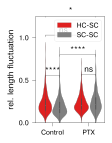

In [34]:
fix, ax = plt.subplots(1, 1, figsize=[1.6, 2.0])
plt.tight_layout()

data = tracked_bonds.loc[
        (tracked_bonds['Experiment'] == 'Control') | 
        (tracked_bonds['Experiment'] == 'PTX')
].copy()

sns.violinplot(
    data=data,
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='type',
    hue_order=['HS', 'SS'],
    inner='box',
    palette=['red', 'gray'],
    linewidth=0.25,

    # bw=0.15
)

box_pairs=[
    (("Control", "HS"), ("Control", "SS")),
    (("PTX", "SS"), ("PTX", "HS")),
    (("Control", "SS"), ("PTX", "SS")),
    (("Control", "HS"), ("PTX", "HS")),
    (("Control", "HS"), ("PTX", "SS")),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=data,
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='type',
    hue_order=['HS', 'SS'],
)
annotator.configure(
    test='Mann-Whitney',
    line_width=0.25,
    fontsize=labelsize,
)
annotator.apply_and_annotate()


ax.set_ylabel('rel. length fluctuation')
ax.set_xlabel('')
ax.set_ylim([0, 1.25])
ax.set_yticks([0., 0.5, 1.])

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['HC-SC', 'SC-SC'], title='', loc='upper right')

data = None
del data

plt.savefig("{}/{}".format(figure_path,
                           "bond_length_fluctuation_Control_PTX.svg"))

## Axial fluctuations

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

aligned vs. other: Welch's t-test independent samples, P_val:3.364e-05 t=-4.294e+00


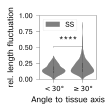

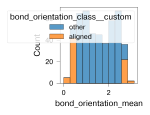

In [40]:
fix, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
plt.tight_layout()

data = tracked_bonds.loc[tracked_bonds['type'] == 'SS'].copy()
data = data.loc[data['Experiment'] == 'Control']
limit = 30 / 180 * math.pi

data['bond_orientation_class__custom'] = np.where(
    data['bond_orientation_mean'] < limit,
    'aligned',
    np.where(
        data['bond_orientation_mean'] > math.pi - limit,
        'aligned',
        'other'
    )
)

sns.violinplot(
    data=data,
    x='bond_orientation_class__custom',
    order=['aligned', 'other'],
    y='bond_length_stddev_norm',
    hue='type',
    inner='box',
    palette=['gray', 'gray'],
    linewidth=linewidth,
    # bw=0.15
)

annotator = Annotator(
    ax,
    [
        ('aligned', 'other'),
    ],
    data=data,
    x='bond_orientation_class__custom',
    order=['aligned', 'other'],
    y='bond_length_stddev_norm',
)
annotator.configure(
    test="t-test_welch",
    # test='Mann-Whitney',
    line_width=linewidth,
)
annotator.apply_and_annotate()

ax.set_xlabel('Angle to tissue axis')
ax.set_xticklabels([r'$< 30 \degree$',r'$\geq 30 \degree$'])

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 1.])
ax.legend(loc='upper left')

plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation__Control.svg"))

fix, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
sns.histplot(
    data=data,
    x='bond_orientation_mean',
    hue='bond_orientation_class__custom',
    binrange=[0, math.pi],
    multiple='stack'
)

data = None
del data

Index(['type', 'tracked_frames', 'tracked_time', 'Experiment', 'position',
       'filepath', 'bond_length_mean', 'bond_excess_length_mean',
       'bond_length_stddev_norm', 'bond_excess_length_stddev_norm',
       'bond_excess_length_stddev', 'bond_length_variance_norm',
       'bond_length_running_stddev_norm', 'bond_orientation_mean',
       'bond_orientation_stddev', 'bond_orientation_class',
       'bond_orientation_class__by_2', 'class__', 'class', 'cilium_rho__mean',
       'cilium_rho__max', 'cilium_rho__min', 'cilium_rho__std',
       'cilium_angular_distance__mean', 'cilium_angular_distance__max',
       'cilium_angular_distance__min', 'cilium_angular_distance__std',
       'bond_orientation_class__custom'],
      dtype='object')
bond_orientation_class__custom
aligned    136
other      815
Name: type, dtype: int64
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ***

Control_aligned vs. ML7_aligned: Welch's t-test independent samples, P_val:6.997e-05 t=-4.174e+00
Control_other vs. ML7_other: Welch's t-test independent samples, P_val:8.852e-08 t=-5.400e+00
Index(['type', 'tracked_frames', 'tracked_time', 'Experiment', 'position',
       'filepath', 'bond_length_mean', 'bond_excess_length_mean',
       'bond_length_stddev_norm', 'bond_excess_length_stddev_norm',
       'bond_excess_length_stddev', 'bond_length_variance_norm',
       'bond_length_running_stddev_norm', 'bond_orientation_mean',
       'bond_orientation_stddev', 'bond_orientation_class',
       'bond_orientation_class__by_2', 'class__', 'class', 'cilium_rho__mean',
       'cilium_rho__max', 'cilium_rho__min', 'cilium_rho__std',
       'cilium_angular_distance__mean', 'cilium_angular_distance__max',
       'cilium_angular_distance__min', 'cilium_angular_distance__std',
       'bond_orientation_class__custom'],
      dtype='object')
bond_orientation_class__custom
aligned    121
other      

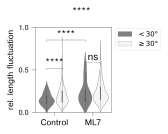

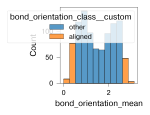

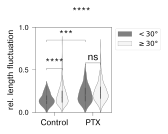

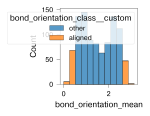

In [41]:
for Experiment in tracked_bonds['Experiment'].unique():
    if Experiment == 'Control':
        continue
    fix, ax = plt.subplots(1, 1, figsize=(1.7, 1.7))
    plt.tight_layout()

    data = tracked_bonds.loc[tracked_bonds['type'] == 'SS']
    data = data.loc[(data['Experiment'] == 'Control') | (data['Experiment'] == Experiment)]
    limit = 30 / 180 * math.pi
    data['bond_orientation_class__custom'] = np.where(
        (data['bond_orientation_mean'] < limit) | (data['bond_orientation_mean'] > math.pi - limit),
        'aligned',
        'other'
    )
    print(data.columns)
    # print(np.unique(data['filename']))
    print(data.groupby(by='bond_orientation_class__custom').count()['type'])

    order=['Control', Experiment]
    sns.violinplot(
        data=data,
        x='Experiment',
        order=order,
        y='bond_length_stddev_norm',
        hue='bond_orientation_class__custom',
        hue_order=['aligned', 'other'],
        inner='box',
        palette=['gray', 'whitesmoke'],
        linewidth=linewidth
        # bw=0.15
    )

    annotator = Annotator(
        ax,
        [
            (('Control', 'aligned'), ('Control', 'other')),
            ((Experiment, 'aligned'), (Experiment, 'other')),
            
            (('Control', 'aligned'), (Experiment, 'aligned')),
            (('Control', 'other'), (Experiment, 'other')),
        ],
        data=data,
        x='Experiment',
        order=order,
        y='bond_length_stddev_norm',
        hue='bond_orientation_class__custom',
        hue_order=['aligned', 'other'],
    )
    annotator.configure(
        test="t-test_welch",
        # test='Mann-Whitney',
        line_width=linewidth,
    )
    annotator.apply_and_annotate()

    # ax.set_xlabel('Angle to tissue axis')
    # ax.set_xticklabels([r'$< 30 \degree$',r'$\geq 30 \degree$'])

    ax.set_ylabel('rel. length fluctuation')
    ax.set_ylim([0, 1.])
    ax.set_yticks([0, 0.5, 1.])

    ax.set_xlabel('')
    ax.set_xticklabels(order, fontsize=labelsize)


    leg_handles = ax.get_legend_handles_labels()[0]
    ax.legend(
        leg_handles,
        [r'$< {:.0f} \degree$'.format(limit/math.pi*180), 
         r'$\geq {:.0f} \degree$'.format(limit/math.pi*180)],
        fontsize=ticksize,
        title='',
        bbox_to_anchor=(1,1.025)
    )
    # mpl.pyplot.legend()

    # ax.legend(loc='upper left')

    plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation__{}.svg".format(Experiment)))

    fix, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
    sns.histplot(
        data=data,
        x='bond_orientation_mean',
        hue='bond_orientation_class__custom',
        binrange=[0, math.pi],
        multiple='stack'
    )

2023-12-18 16:34:11,110 :: WARNING :: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

aligned vs. intermediate: Welch's t-test independent samples, P_val:1.801e-04 t=-3.827e+00
intermediate vs. orthogonal: Welch's t-test independent samples, P_val:8.865e-01 t=-1.428e-01
aligned vs. orthogonal: Welch's t-test independent samples, P_val:2.652e-04 t=-3.717e+00


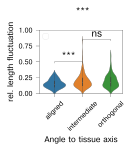

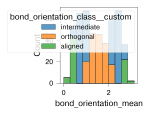

In [61]:
fix, ax = plt.subplots(1, 1, figsize=(1.8, 1.4))
plt.tight_layout()

data = tracked_bonds.loc[tracked_bonds['type'] == 'SS'].copy()
data = data.loc[data['Experiment'] == 'Control']

data['bond_orientation_class__custom'] = np.where(
    np.abs(data['bond_orientation_mean'] - math.pi/2) < math.pi / 6,
    'orthogonal',
    np.where(
        np.abs(data['bond_orientation_mean'] - math.pi/2) < math.pi / 3,
        'intermediate',
        'aligned'
    )
)

sns.violinplot(
    data=data,
    x='bond_orientation_class__custom',
    order=['aligned', 'intermediate', 'orthogonal'],
    y='bond_length_stddev_norm',
    inner='box',
    linewidth=linewidth,
)

annotator = Annotator(
    ax,
    [
        ('aligned', 'intermediate'),
        ('intermediate', 'orthogonal'),
        ('aligned', 'orthogonal'),
    ],
    data=data,
    x='bond_orientation_class__custom',
    order=['aligned', 'intermediate', 'orthogonal'],
    y='bond_length_stddev_norm',
)
annotator.configure(
    test="t-test_welch",
    line_width=linewidth,
)
annotator.apply_and_annotate()

ax.set_xlabel('Angle to tissue axis')
ax.set_xticklabels(['aligned', 'intermediate', 'orthogonal'], rotation=45)

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 1.])
ax.legend(loc='upper left')

plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation__Control__new.svg"))

fix, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
sns.histplot(
    data=data,
    x='bond_orientation_mean',
    hue='bond_orientation_class__custom',
    binrange=[0, math.pi],
    multiple='stack'
)

data = None
del data

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ML7_intermediate vs. ML7_orthogonal: Welch's t-test independent samples, P_val:2.293e-01 t=1.204e+00
Control_aligned vs. Control_intermediate: Welch's t-test independent samples, P_val:1.801e-04 t=-3.827e+00
Control_intermediate vs. Control_orthogonal: Welch's t-test independent samples, P_val:8.865e-01 t=-1.428e-01
ML7_aligned vs. ML7_intermediate: Welch's t-test independent samples, P_val:5.585e-01 t=-5.872e-01
ML7_aligned vs. ML7_orthogonal: Welch's t-test independent samples, P_val:8.454e-01 t=1.955e-01
Control_aligned vs. Control_orthogonal: Welch's t-test independent samples, P_val:2.652e-04 t=-3.717e+00
Control_orthogonal vs. ML7_orthogonal: Welch's t-test independent samples, P_val:6.024e-03 t=-2.766e+00
Control_aligned vs. ML7_aligned: Welch's t-test independent samples, P_val:5.471e-05 t=-4.236e+00

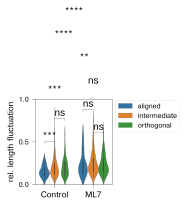

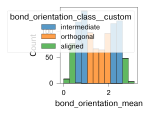

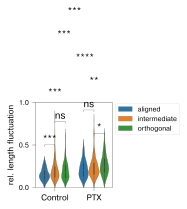

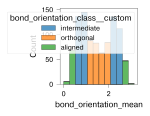

In [65]:
for Experiment in tracked_bonds['Experiment'].unique():
    if Experiment == 'Control':
        continue
    fix, ax = plt.subplots(1, 1, figsize=(1.7, 1.7))
    plt.tight_layout()

    data = tracked_bonds.loc[tracked_bonds['type'] == 'SS']
    data = data.loc[(data['Experiment'] == 'Control') | (data['Experiment'] == Experiment)]
    
    data['bond_orientation_class__custom'] = np.where(
        np.abs(data['bond_orientation_mean'] - math.pi/2) < math.pi / 6,
        'orthogonal',
        np.where(
            np.abs(data['bond_orientation_mean'] - math.pi/2) < math.pi / 3,
            'intermediate',
            'aligned'
        )
    )

    order=['Control', Experiment]
    sns.violinplot(
        data=data,
        x='Experiment',
        order=order,
        y='bond_length_stddev_norm',
        hue='bond_orientation_class__custom',
        hue_order=['aligned', 'intermediate', 'orthogonal'],
        inner='box',
        linewidth=linewidth
        # bw=0.15
    )

    annotator = Annotator(
        ax,
        [
            (('Control', 'aligned'), ('Control', 'intermediate')),
            (('Control', 'intermediate'), ('Control', 'orthogonal')),
            (('Control', 'aligned'), ('Control', 'orthogonal')),
            ((Experiment, 'aligned'), (Experiment, 'intermediate')),
            ((Experiment, 'intermediate'), (Experiment, 'orthogonal')),
            ((Experiment, 'aligned'), (Experiment, 'orthogonal')),
            
            (('Control', 'aligned'), (Experiment, 'aligned')),
            (('Control', 'intermediate'), (Experiment, 'intermediate')),
            (('Control', 'orthogonal'), (Experiment, 'orthogonal')),
        ],
        data=data,
        x='Experiment',
        order=order,
        y='bond_length_stddev_norm',
        hue='bond_orientation_class__custom',
        hue_order=['aligned', 'intermediate', 'orthogonal'],
    )
    annotator.configure(
        test="t-test_welch",
        # test='Mann-Whitney',
        line_width=linewidth,
    )
    annotator.apply_and_annotate()

    ax.set_xlabel('Angle to tissue axis')

    ax.set_ylabel('rel. length fluctuation')
    ax.set_ylim([0, 1.])
    ax.set_yticks([0, 0.5, 1.])

    ax.set_xlabel('')
    ax.set_xticklabels(order, fontsize=labelsize)


    leg_handles = ax.get_legend_handles_labels()[0]
    ax.legend(
        leg_handles,
        ['aligned', 'intermediate', 'orthogonal'],
        # [r'$< {:.0f} \degree$'.format(limit/math.pi*180), 
        #  r'$\geq {:.0f} \degree$'.format(limit/math.pi*180)],
        fontsize=ticksize,
        title='',
        bbox_to_anchor=(1,1.025)
    )
    # mpl.pyplot.legend()

    # ax.legend(loc='upper left')

    plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation__{}__new.svg".format(Experiment)))

    fix, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
    sns.histplot(
        data=data,
        x='bond_orientation_mean',
        hue='bond_orientation_class__custom',
        binrange=[0, math.pi],
        multiple='stack'
    )

## Fluctuations w.r.t. HC polarity

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control_True vs. Control_False: Welch's t-test independent samples, P_val:2.024e-04 t=-3.776e+00


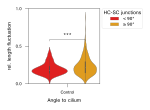

In [105]:
fix, ax = plt.subplots(1, 1, figsize=[1.4, 1.4])
plt.tight_layout()

Experiment = 'Control'
HS_bonds = tracked_bonds.loc[tracked_bonds['type'] == 'HS'].copy()
HS_bonds = HS_bonds.loc[HS_bonds['Experiment'] == Experiment]

frame = cells.loc[cells['sample_id']==sample_id].copy()
frame = frame.loc[frame['Experiment']==Experiment]
frame = frame.loc[~frame['is_border_cell']]
HS_bonds['is_close'] = HS_bonds['cilium_angular_distance__mean'] < math.pi / 2

sns.violinplot(
    data=HS_bonds,
    x='Experiment',
    hue='is_close', hue_order=[True, False],
    y='bond_length_stddev_norm',
    inner='box',
    palette=['red', 'orange'],
    linewidth=linewidth,
)

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(
    leg_handles,
    [r'$<90\degree$', r'$\geq90\degree$'],
    fontsize=ticksize,
    title='HC-SC junctions',
    loc='upper left',
    bbox_to_anchor=(1,1.025)
)

box_pairs=[
    (("Control", False), ("Control", True)),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=HS_bonds,
    x='Experiment',
    hue='is_close', hue_order=[True, False],
    y='bond_length_stddev_norm',
)
annotator.configure(
    test='t-test_welch',
    line_width=linewidth,
)
annotator.apply_and_annotate()


ax.set_ylabel('rel. length fluctuation')
ax.set_xlabel('Angle to cilium')
ax.set_ylim([0, 1.])
ax.set_yticks([0., 0.5, 1.])


plt.savefig("{}/{}".format(figure_path,
                           "bond_length_fluctuation_Control_HC_angle.svg"))

/tmp/ipykernel_84137/588090651.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_close'] = (data['cilium_angular_distance__mean'] < math.pi / 2).copy()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PTX_True vs. PTX_False: Mann-Whitney-Wilcoxon test two-sided, P_val:6.327e-01 U_stat=1.756e+04
Control_True vs. Control_False: Mann-Whitney-Wilcoxon test two-sided, P_val:7.310e-03 U_stat=1.490e+04
Control_True vs. PTX_True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.608e-03 U_stat=5.235e+03
Control_False vs. PTX_False: Mann-Whitney-Wilcoxon test two-sided, P_val:5.061e-01 U_stat=4.792e+04


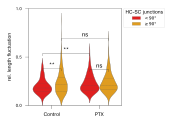

In [108]:
fix, ax = plt.subplots(1, 1, figsize=[1.7, 1.7])
plt.tight_layout()

HS_bonds = tracked_bonds.loc[tracked_bonds['type'] == 'HS']
mask = np.where(
    HS_bonds['Experiment'] == 'Control',
    True,
    HS_bonds['Experiment'] == 'PTX',
)
data = HS_bonds.loc[mask]

frame = cells.loc[cells['sample_id']==sample_id].copy()
frame = frame.loc[frame['Experiment']==Experiment]
frame = frame.loc[~frame['is_border_cell']]
data['is_close'] = (data['cilium_angular_distance__mean'] < math.pi / 2).copy()

order=['Control', 'PTX']
sns.violinplot(
    data=data,
    x='Experiment', order=order,
    y='bond_length_stddev_norm',
    hue='is_close', hue_order=[True, False],
    inner='quart',
    palette=['red', 'orange'],
    linewidth=linewidth,
    # bw=0.15
)

box_pairs=[
    (("Control", True), ("Control", False)),
    (("PTX", True), ("PTX", False)),
    (("Control", True), ("PTX", True)),
    (("Control", False), ("PTX", False)),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=data,
    x='Experiment', order=order,
    y='bond_length_stddev_norm',
    hue='is_close', hue_order=[True, False],
)
annotator.configure(
    test='Mann-Whitney',
    line_width=linewidth,
)
annotator.apply_and_annotate()


ax.set_ylabel('rel. length fluctuation')
ax.set_xlabel('')
ax.set_xticklabels(order, fontsize=labelsize)
ax.set_ylim([0, 1.])
ax.set_yticks([0., 0.5, 1.])


leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(
    leg_handles,
    [r'$<90\degree$', r'$\geq90\degree$'],
    fontsize=ticksize,
    title='HC-SC junctions',
    loc='upper left',
    bbox_to_anchor=(1,1.025)
)


plt.savefig("{}/{}".format(figure_path,
                           "bond_length_fluctuation_Control_HC_angle__PTX.svg"))

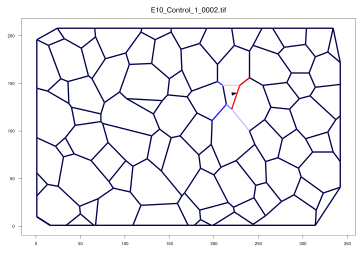

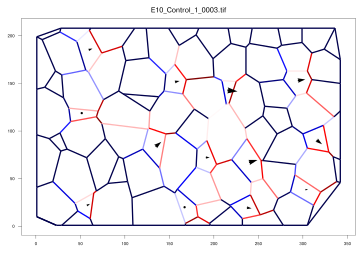

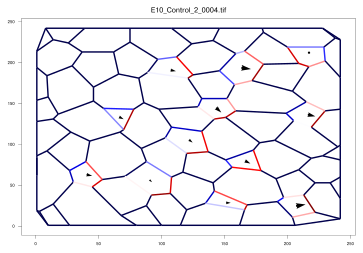

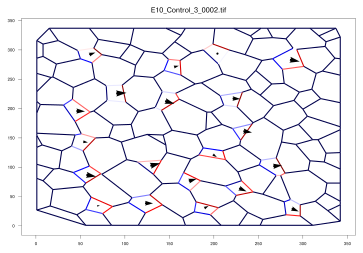

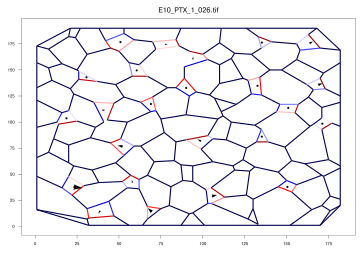

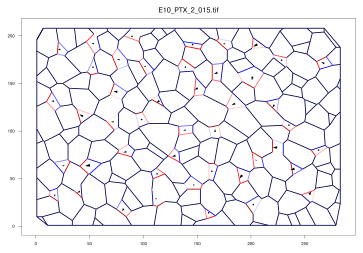

In [112]:
for frame in np.unique(bonds.loc[~np.isnan(bonds['cilium_angular_distance']), 'filename']):
    frame_bonds = bonds.loc[bonds['filename']==frame]
    fig, ax = plt.subplots(1, 1)
    # color = np.where(frame_bonds['type'] == 'SS', 'gray', 'black')
    # color = np.where(frame_bonds['type'] == 'HS', 'orange', color)
    # color = np.where(frame_bonds['type'] == 'HH', 'red', color)
    # color = np.where(frame_bonds['type'] == 'border', 'skyblue', color)
    # color = np.where(frame_bonds['type'] == 'border_plus_one',
    #                 'deepskyblue',
    #                 color)
    color=np.where(
        ~np.isnan(frame_bonds['cilium_angular_distance']),
        frame_bonds['cilium_angular_distance'],
        0
    )
    ax.quiver(
        frame_bonds['vx_1_x'],
        frame_bonds['vx_1_y'],
        frame_bonds['vx_2_x'] - frame_bonds['vx_1_x'],
        frame_bonds['vx_2_y'] - frame_bonds['vx_1_y'],
        color,
        cmap='seismic',
        clim=[0, math.pi],
        # vmin=0,
        # vmax=math.pi,
        scale_units='xy', angles='xy', scale=1,
        headwidth=0, headlength=0,headaxislength=0,
    )

    frame_cells = cells.loc[cells['filename']==frame]
    rho = (frame_cells['area_cells']/ math.pi)**0.5
    ax.quiver(
        frame_cells['center_x_cells'],
        frame_cells['center_y_cells'],
        rho * frame_cells['cilium_rho_corrected'] * np.cos(frame_cells['cilium_phi_corrected']),
        rho * frame_cells['cilium_rho_corrected'] * np.sin(frame_cells['cilium_phi_corrected']),
        color='black',
        scale_units='xy', angles='xy', scale=1,
    )

    ax.set_title(frame)

## Temporal development

/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwa

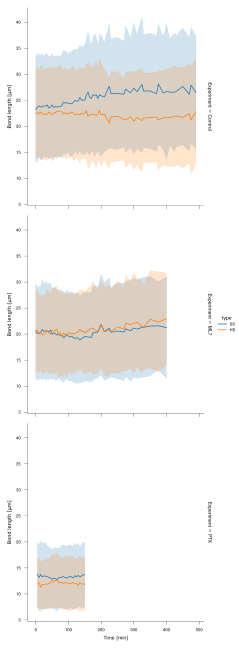

In [114]:
g = sns.FacetGrid(
    bonds,
    # col="",
    row="Experiment",
    hue='type',
    hue_order=['SS', 'HS'],
    margin_titles=True,
    sharey="col", sharex=True)


g.map_dataframe(
    sns.lineplot,
    x="time",
    y="bond_length_in_px",
    markers=True, ci='sd', err_style='band')

g.set_xlabels("Time [min]")
g.set_ylabels("Bond length [$\mu$m]")

g.add_legend()

plt.savefig("{}/{}".format(figure_path, "bonds_length_development.svg"))


/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/julian/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwa

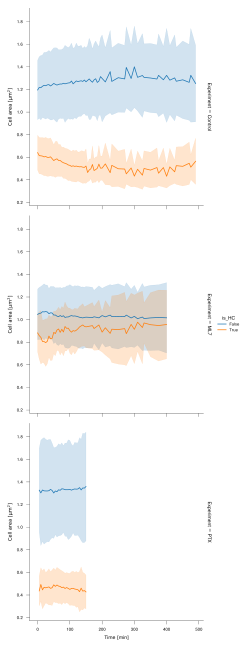

In [115]:
g = sns.FacetGrid(
    cells,
    # col="",
    row="Experiment",
    hue='is_HC',
    # hue_order=['SS', 'HS'],
    margin_titles=True,
    sharey="col", sharex=True)


g.map_dataframe(
    sns.lineplot,
    x="time",
    y="normalized_area_cells",
    # style='sample_id',
    markers=True, ci='sd', err_style='band')

g.set_xlabels("Time [min]")
g.set_ylabels("Cell area [$\mu$m$^2$]")

g.add_legend()

plt.savefig("{}/{}".format(figure_path, "cell_area_development.svg"))

In [120]:
raise

RuntimeError: No active exception to reraise

## Other

ML7_HS v.s. ML7_SS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.217e-01
Control_HS v.s. Control_SS: Welch's t-test independent samples with Bonferroni correction, P_val=1.757e-06 stat=5.166e+00
PTX_HS v.s. PTX_SS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.169e+00
Control_SS v.s. ML7_SS: Welch's t-test independent samples with Bonferroni correction, P_val=4.965e-10 stat=-6.576e+00


/home/julian/.local/lib/python3.10/site-packages/statannot/statannot.py:593: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.draw()


Control_HS v.s. ML7_HS: Welch's t-test independent samples with Bonferroni correction, P_val=8.161e-01 stat=-1.493e+00
Control_HS v.s. PTX_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-8.906e-01


/tmp/ipykernel_84137/3804999887.py:40: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation.svg"))
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


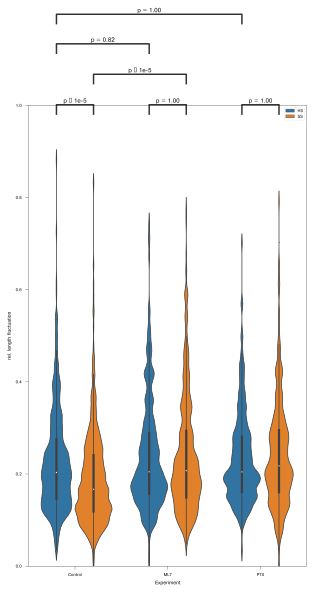

In [118]:
fix, ax = plt.subplots(1, 1, figsize=(5, 8.5))

sns.violinplot(
    # data=tracked_bonds.loc[tracked_bonds['bond_length_stddev'] < 0.7],
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='type',
    hue_order=['HS', 'SS'],
    inner='box',
    bw=0.1
)

statannot.add_stat_annotation(
    ax,
    # data=tracked_bonds.loc[tracked_bonds['bond_length_stddev'] < 0.7],
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='type',
    hue_order=['HS', 'SS'],
    box_pairs=[
        (("Control", "SS"), ("Control", "HS")),
        (("ML7", "SS"), ("ML7", "HS")),
        (("PTX", "SS"), ("PTX", "HS")),
        (("Control", "SS"), ("ML7", "SS")),
        (("Control", "HS"), ("ML7", "HS")),
        (("Control", "HS"), ("PTX", "HS")),
    ],
    test="t-test_welch",
    text_format="simple",
    loc="outside",
)

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 1.])
ax.legend(loc='upper right')


plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation.svg"))

ML7_HS v.s. ML7_SS: Welch's t-test independent samples with Bonferroni correction, P_val=2.389e-02 stat=2.890e+00
Control_HS v.s. Control_SS: Welch's t-test independent samples with Bonferroni correction, P_val=3.575e-01 stat=1.886e+00
PTX_HS v.s. PTX_SS: Welch's t-test independent samples with Bonferroni correction, P_val=1.754e-02 stat=2.985e+00
Control_SS v.s. ML7_SS: Welch's t-test independent samples with Bonferroni correction, P_val=5.810e-15 stat=8.178e+00
Control_HS v.s. ML7_HS: Welch's t-test independent samples with Bonferroni correction, P_val=9.067e-08 stat=5.719e+00
Control_HS v.s. PTX_HS: Welch's t-test independent samples with Bonferroni correction, P_val=2.550e-31 stat=1.234e+01


/home/julian/.local/lib/python3.10/site-packages/statannot/statannot.py:593: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.draw()
/tmp/ipykernel_84137/2981249191.py:40: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.savefig("{}/{}".format(figure_path, "bond_excess_length.svg"))
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


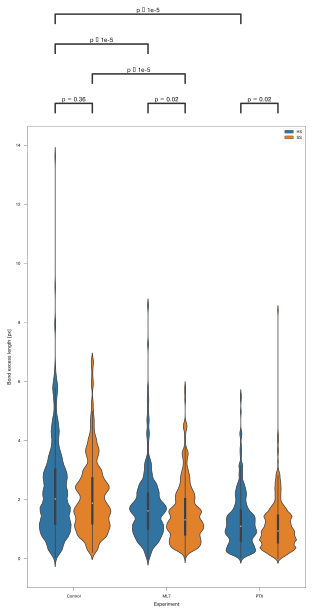

In [119]:
fix, ax = plt.subplots(1, 1, figsize=(5, 8.5))

sns.violinplot(
    # data=tracked_bonds.loc[tracked_bonds['bond_length_stddev'] < 0.7],
    data=tracked_bonds,
    x='Experiment',
    y='bond_excess_length_mean',
    hue='type',
    hue_order=['HS', 'SS'],
    inner='box',
    bw=0.1
)

statannot.add_stat_annotation(
    ax,
    # data=tracked_bonds.loc[tracked_bonds['bond_length_stddev'] < 0.7],
    data=tracked_bonds,
    x='Experiment',
    y='bond_excess_length_mean',
    hue='type',
    hue_order=['HS', 'SS'],
    box_pairs=[
        (("Control", "SS"), ("Control", "HS")),
        (("ML7", "SS"), ("ML7", "HS")),
        (("PTX", "SS"), ("PTX", "HS")),
        (("Control", "SS"), ("ML7", "SS")),
        (("Control", "HS"), ("ML7", "HS")),
        (("Control", "HS"), ("PTX", "HS")),
    ],
    test="t-test_welch",
    text_format="simple",
    loc="outside",
)

ax.set_ylabel('Bond excess length [px]')
# ax.set_ylim([0, 1.])
ax.legend(loc='upper right')


plt.savefig("{}/{}".format(figure_path, "bond_excess_length.svg"))

In [ ]:
fix, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
plt.tight_layout()

data = tracked_bonds.loc[tracked_bonds['type'] == 'SS']
data = data.loc[data['Experiment'] == 'Control']
limit = 20 / 180 * math.pi

data['bond_orientation_class__custom'] = np.where(
    data['bond_orientation_mean'] < limit,
    'aligned',
    np.where(
        data['bond_orientation_mean'] > math.pi - limit,
        'aligned',
        'other'
    )
)
print(data.columns)
print(np.unique(data['filename']))
print(data.groupby(by='bond_orientation_class__custom').count()['type'])

sns.violinplot(
    data=data,
    x='bond_orientation_class__custom',
    order=['aligned', 'other'],
    y='bond_length_stddev_norm',
    hue='type',
    inner='box',
    palette=['gray', 'gray'],
    linewidth=linewidth,
    # bw=0.15
)

annotator = Annotator(
    ax,
    [
        ('aligned', 'other'),
    ],
    data=data,
    x='bond_orientation_class__custom',
    order=['aligned', 'other'],
    y='bond_length_stddev_norm',
)
annotator.configure(
    test="t-test_welch",
    # test='Mann-Whitney',
    line_width=linewidth,
)
annotator.apply_and_annotate()

ax.set_xlabel('Angle to tissue axis')
ax.set_xticklabels([r'$< 30 \degree$',r'$\geq 30 \degree$'])

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 1.])
ax.legend(loc='upper left')

plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation__Control.svg"))

fix, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
sns.histplot(
    data=data,
    x='bond_orientation_mean',
    hue='bond_orientation_class__custom',
    binrange=[0, math.pi],
    multiple='stack'
)

In [ ]:
for Experiment in tracked_bonds['Experiment'].unique():
    if Experiment == 'Control':
        continue
    fix, ax = plt.subplots(1, 1, figsize=(1.7, 1.7))
    plt.tight_layout()

    data = tracked_bonds.loc[tracked_bonds['type'] == 'SS']
    data = data.loc[(data['Experiment'] == 'Control') | (data['Experiment'] == Experiment)]
    limit = 30 / 180 * math.pi
    data['bond_orientation_class__custom'] = np.where(
        (data['bond_orientation_mean'] < limit) | (data['bond_orientation_mean'] > math.pi - limit),
        'aligned',
        'other'
    )
    print(data.columns)
    # print(np.unique(data['filename']))
    print(data.groupby(by='bond_orientation_class__custom').count()['type'])

    order=['Control', Experiment]
    sns.violinplot(
        data=data,
        x='Experiment',
        order=order,
        y='bond_length_stddev_norm',
        hue='bond_orientation_class__custom',
        hue_order=['aligned', 'other'],
        inner='box',
        palette=['gray', 'whitesmoke'],
        linewidth=linewidth
        # bw=0.15
    )

    annotator = Annotator(
        ax,
        [
            (('Control', 'aligned'), ('Control', 'other')),
            ((Experiment, 'aligned'), (Experiment, 'other')),
            
            (('Control', 'aligned'), (Experiment, 'aligned')),
            (('Control', 'other'), (Experiment, 'other')),
        ],
        data=data,
        x='Experiment',
        order=order,
        y='bond_length_stddev_norm',
        hue='bond_orientation_class__custom',
        hue_order=['aligned', 'other'],
    )
    annotator.configure(
        test="t-test_welch",
        # test='Mann-Whitney',
        line_width=linewidth,
    )
    annotator.apply_and_annotate()

    # ax.set_xlabel('Angle to tissue axis')
    # ax.set_xticklabels([r'$< 30 \degree$',r'$\geq 30 \degree$'])

    ax.set_ylabel('rel. length fluctuation')
    ax.set_ylim([0, 1.])
    ax.set_yticks([0, 0.5, 1.])

    ax.set_xlabel('')
    ax.set_xticklabels(order, fontsize=labelsize)


    leg_handles = ax.get_legend_handles_labels()[0]
    ax.legend(
        leg_handles,
        [r'$< {:.0f} \degree$'.format(limit/math.pi*180), 
         r'$\geq {:.0f} \degree$'.format(limit/math.pi*180)],
        fontsize=ticksize,
        title='',
        bbox_to_anchor=(1,1.025)
    )
    # mpl.pyplot.legend()

    # ax.legend(loc='upper left')

    plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation__{}.svg".format(Experiment)))

    fix, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
    sns.histplot(
        data=data,
        x='bond_orientation_mean',
        hue='bond_orientation_class__custom',
        binrange=[0, math.pi],
        multiple='stack'
    )

In [ ]:
for Experiment in tracked_bonds['Experiment'].unique():
    if Experiment == 'Control':
        continue
    fix, ax = plt.subplots(1, 1, figsize=(1.7, 1.7))
    plt.tight_layout()

    data = tracked_bonds.loc[tracked_bonds['type'] == 'SS']
    data = data.loc[(data['Experiment'] == 'Control') | (data['Experiment'] == Experiment)]
    limit = 30 / 180 * math.pi
    data['bond_orientation_class__custom'] = np.where(
        (data['bond_orientation_mean'] < limit) | (data['bond_orientation_mean'] > math.pi - limit),
        'aligned',
        np.where(
            np.abs(data['bond_orientation_mean'] - math.pi / 2) < limit,
            'not-aligned',
            'mid'
        )
    )
    print(data.columns)
    # print(np.unique(data['filename']))
    print(data.groupby(by='bond_orientation_class__custom').count()['type'])

    order=['Control', Experiment]
    sns.violinplot(
        data=data,
        x='Experiment',
        order=order,
        y='bond_length_stddev_norm',
        hue='bond_orientation_class__custom',
        hue_order=['aligned', 'not-aligned'],
        inner='box',
        palette=['gray', 'whitesmoke'],
        linewidth=linewidth
        # bw=0.15
    )

    # ax.set_xlabel('Angle to tissue axis')
    # ax.set_xticklabels([r'$< 30 \degree$',r'$\geq 30 \degree$'])

    ax.set_ylabel('rel. length fluctuation')
    ax.set_ylim([0, 1.])
    ax.set_yticks([0, 0.5, 1.])

    ax.set_xlabel('')
    ax.set_xticklabels(order, fontsize=labelsize)


    leg_handles = ax.get_legend_handles_labels()[0]
    ax.legend(
        leg_handles,
        [r'$< {:.0f} \degree$'.format(limit/math.pi*180), 
         r'$> {:.0f} \degree$'.format(2*limit/math.pi*180)],
        fontsize=ticksize,
        title='',
        bbox_to_anchor=(1,1.025)
    )
    # mpl.pyplot.legend()

    # ax.legend(loc='upper left')

    annotator = Annotator(
        ax,
        [
            (('Control', 'aligned'), ('Control', 'not-aligned')),
            ((Experiment, 'aligned'), (Experiment, 'not-aligned')),
            
            (('Control', 'aligned'), (Experiment, 'aligned')),
            (('Control', 'not-aligned'), (Experiment, 'not-aligned')),
        ],
        data=data,
        x='Experiment',
        order=order,
        y='bond_length_stddev_norm',
        hue='bond_orientation_class__custom',
        hue_order=['aligned', 'mid', 'not-aligned'],
    )
    annotator.configure(
        test="t-test_welch",
        # test='Mann-Whitney',
        line_width=linewidth,
    )
    annotator.apply_and_annotate()

    plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation__{}__test.svg".format(Experiment)))

    fix, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
    sns.histplot(
        data=data,
        x='bond_orientation_mean',
        hue='bond_orientation_class__custom',
        binrange=[0, math.pi],
        multiple='stack'
    )

In [ ]:
print()

(0.0, 0.5)

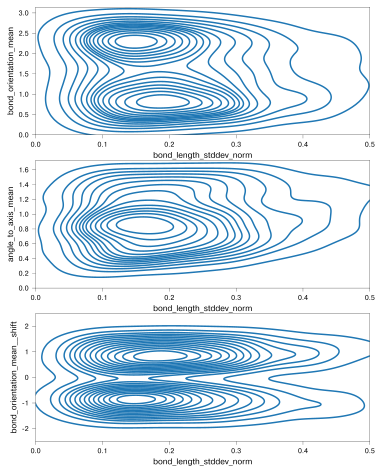

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[6, 8])
sns.kdeplot(data=data, x='bond_length_stddev_norm', y='bond_orientation_mean', levels=15, ax=ax1)
ax1.set_xlim(0, 0.5)
ax1.set_ylim(0, math.pi)

data['angle_to_axis_mean'] = np.where(
    data['bond_orientation_mean'] < math.pi / 2,
    data['bond_orientation_mean'],
    math.pi - data['bond_orientation_mean']
)

sns.kdeplot(data=data, x='bond_length_stddev_norm', y='angle_to_axis_mean', levels=15, ax=ax2)
ax2.set_xlim(0, 0.5)
ax2.set_ylim(0, math.pi/2*1.1)

data['bond_orientation_mean__shift'] = np.where(
    data['bond_orientation_mean'] < math.pi / 2,
    data['bond_orientation_mean'],
    -(math.pi - data['bond_orientation_mean'])
)
sns.kdeplot(data=data, x='bond_length_stddev_norm', y='bond_orientation_mean__shift', levels=15, ax=ax3)
ax3.set_xlim(0, 0.5)
# ax3.set_ylim(0, math.pi/2*1.1)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



TypeError: sequence item 0: expected str instance, numpy.float64 found

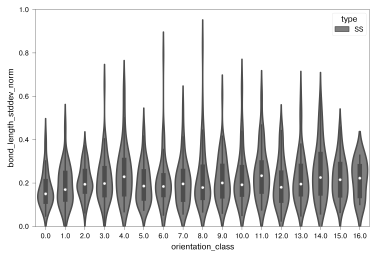

In [67]:
fig, ax = plt.subplots(1, 1, )
data = data.sort_values(by='angle_to_axis_mean')
count = data.shape[0]

for i, (idi, bond) in enumerate(data.iterrows()):
    data.loc[idi, 'orientation_class'] = np.floor(i / 60)



# data['orientation_class'] = np.floor(data['bond_orientation_mean'] / math.pi * 6)
sns.violinplot(
    data=data,
    x='orientation_class',
    # order=['aligned', 'other'],
    y='bond_length_stddev_norm',
    hue='type',
    inner='box',
    palette=['gray', 'gray']
    # bw=0.15
)
ax.set_ylim([0, 1])
annotator = Annotator(
    ax,
    [
        (0.0, 1.0),
        (1.0, 2.0),
        (2.0, 3.0),
        (3.0, 4.0),
        (4.0, 5.0),
        (5.0, 6.0),
        (6.0, 7.0),
        (7.0, 0.0),

    ],
    data=data,
    x='orientation_class',
    y='bond_length_stddev_norm',
)
annotator.configure(
    test="t-test_welch",
    # test='Mann-Whitney',
    line_width=0.75,
)
annotator.apply_and_annotate()

print(data.groupby(by='orientation_class').count()['type'])

fix, ax = plt.subplots(1, 1)
sns.histplot(
    data=data,
    x='bond_orientation_mean',
    hue='orientation_class',
    binrange=[0, math.pi],
    multiple='stack'
)

PTX_vertical v.s. PTX_diagonal: Welch's t-test independent samples with Bonferroni correction, P_val=5.566e-02 stat=2.793e+00
Control_vertical v.s. Control_diagonal: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.428e-01
ML7_vertical v.s. ML7_diagonal: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.206e+00
PTX_vertical v.s. PTX_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=4.508e-02 stat=2.907e+00
ML7_vertical v.s. ML7_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.861e-01
Control_vertical v.s. Control_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=2.652e-03 stat=3.717e+00
Control_horizontal v.s. ML7_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=6.997e-04 stat=-4.174e+00
Control_vertical v.s. ML7_vertical: Welch's t-test independent samples with Bonferron

/home/julian/.local/lib/python3.10/site-packages/statannot/statannot.py:593: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.draw()


Control_horizontal v.s. PTX_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=3.344e-03 stat=-3.746e+00


/tmp/ipykernel_84137/745445605.py:46: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation.svg"))
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


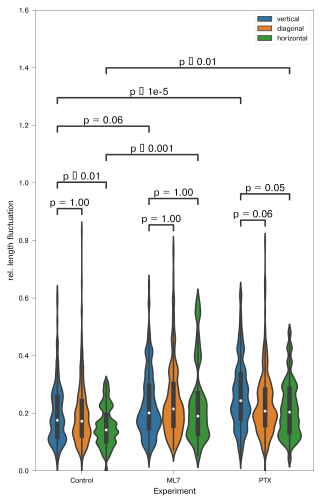

In [68]:
fix, ax = plt.subplots(1, 1, figsize=(5, 8.5))

sns.violinplot(
    data=tracked_bonds.loc[tracked_bonds['type'] == 'SS'],
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='bond_orientation_class',
    hue_order=['vertical', 'diagonal', 'horizontal'],
    inner='box',
    bw=0.15
)

statannot.add_stat_annotation(
    ax,
    data=tracked_bonds.loc[tracked_bonds['type'] == 'SS'],
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='bond_orientation_class',
    hue_order=['vertical', 'diagonal', 'horizontal'],
    box_pairs=[
        (("Control", "vertical"), ("Control", "diagonal")),
        (("Control", "vertical"), ("Control", "horizontal")),

        (("ML7", "vertical"), ("ML7", "diagonal")),
        (("ML7", "vertical"), ("ML7", "horizontal")),

        (("PTX", "vertical"), ("PTX", "diagonal")),
        (("PTX", "vertical"), ("PTX", "horizontal")),

        (("Control", "vertical"), ("ML7", "vertical")),
        (("Control", "horizontal"), ("ML7", "horizontal")),

        (("Control", "vertical"), ("PTX", "vertical")),
        (("Control", "horizontal"), ("PTX", "horizontal")),
    ],
    test="t-test_welch",
    text_format="simple",
    loc="inside",
)

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 1.6])
ax.legend(loc='upper right')


plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation.svg"))

PTX_HS v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.528e+00
Control_HS v.s. Control_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=6.814e-04 stat=4.046e+00
ML7_HS v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-2.009e-01
PTX_HS v.s. PTX_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan


/home/julian/.local/lib/python3.10/site-packages/statannot/statannot.py:593: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.draw()


ML7_HS v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. Control_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_SS_horizontal v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. ML7_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.493e+00
Control_SS_other v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.062e-06 stat=-5.400e+00
Control_HS v.s. PTX_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-8.906e-01
Control_SS_other v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.151e-08 stat=-6.187e+00
Control_SS_horizontal v.s. PTX_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan


/tmp/ipykernel_84137/385365319.py:48: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation_new.svg"))
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


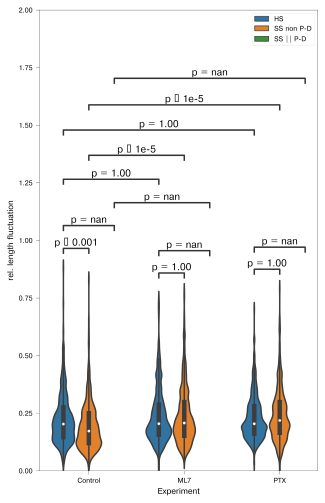

In [69]:
fix, ax = plt.subplots(1, 1, figsize=(5, 8.5))

sns.violinplot(
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='class',
    hue_order=['HS', 'SS non P-D', 'SS || P-D'],
    inner='box',
    bw=0.15
)

statannot.add_stat_annotation(
    ax,
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='class__',
    hue_order=['HS', 'SS_other', 'SS_horizontal'],
    box_pairs=[
        (("Control", "HS"), ("Control", "SS_horizontal")),
        (("Control", "HS"), ("Control", "SS_other")),

        (("ML7", "HS"), ("ML7", "SS_horizontal")),
        (("ML7", "HS"), ("ML7", "SS_other")),

        (("PTX", "HS"), ("PTX", "SS_horizontal")),
        (("PTX", "HS"), ("PTX", "SS_other")),

        (("Control", "HS"), ("ML7", "HS")),
        (("Control", "SS_other"), ("ML7", "SS_other")),
        (("Control", "SS_horizontal"), ("ML7", "SS_horizontal")),

        (("Control", "HS"), ("PTX", "HS")),
        (("Control", "SS_other"), ("PTX", "SS_other")),
        (("Control", "SS_horizontal"), ("PTX", "SS_horizontal")),
    ],
    test="t-test_welch",
    text_format="simple",
    loc="inside",
)

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 2])
ax.legend(loc='upper right')


plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation_new.svg"))

ValueError: Missing hue value `SS_horizontal` in class__ (specified in `pairs`)

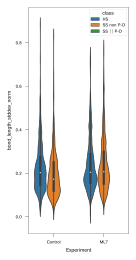

In [70]:
plt.rcParams['font.size'] = 6
plt.rcParams['lines.linewidth'] = 0.75


fix, ax = plt.subplots(1, 1, figsize=(1.8, 3.5))
plt.tight_layout()

sns.violinplot(
    data=tracked_bonds.loc[tracked_bonds['Experiment'] != 'PTX'],
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='class',
    hue_order=['HS', 'SS non P-D', 'SS || P-D'],
    inner='box',
    bw=0.15
)

box_pairs=[
    (("Control", "HS"), ("Control", "SS_horizontal")),
    (("Control", "HS"), ("Control", "SS_other")),

    (("ML7", "HS"), ("ML7", "SS_horizontal")),
    (("ML7", "HS"), ("ML7", "SS_other")),

    # (("PTX", "HS"), ("PTX", "SS_horizontal")),
    # (("PTX", "HS"), ("PTX", "SS_other")),

    (("Control", "HS"), ("ML7", "HS")),
    (("Control", "SS_other"), ("ML7", "SS_other")),
    (("Control", "SS_horizontal"), ("ML7", "SS_horizontal")),

    # (("Control", "HS"), ("PTX", "HS")),
    # (("Control", "SS_other"), ("PTX", "SS_other")),
    # (("Control", "SS_horizontal"), ("PTX", "SS_horizontal")),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=tracked_bonds.loc[tracked_bonds['Experiment'] != 'PTX'],
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='class__',
    hue_order=['HS', 'SS_other', 'SS_horizontal'],
)
annotator.configure(
    test='Mann-Whitney',
    line_width=0.75
)
annotator.apply_and_annotate()


ax.set_ylabel('rel. length fluctuation')
ax.set_xlabel('')
ax.set_ylim([0, 1])
ax.legend(loc='upper right')


plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation_new_no_error.svg"), bbox_inches="tight")
plt.rcParams.update(plt.rcParamsDefault)

ValueError: Missing hue value `SS_horizontal` in class__ (specified in `pairs`)

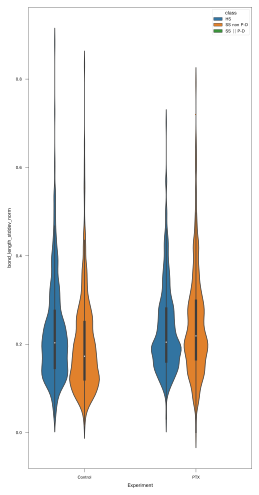

In [71]:
fix, ax = plt.subplots(1, 1, figsize=(4, 8.5))

sns.violinplot(
    data=tracked_bonds.loc[tracked_bonds['Experiment'] != 'ML7'],
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='class',
    hue_order=['HS', 'SS non P-D', 'SS || P-D'],
    inner='box',
    bw=0.15
)

box_pairs=[
    (("Control", "HS"), ("Control", "SS_horizontal")),
    (("Control", "HS"), ("Control", "SS_other")),

    # (("ML7", "HS"), ("ML7", "SS_horizontal")),
    # (("ML7", "HS"), ("ML7", "SS_other")),

    (("PTX", "HS"), ("PTX", "SS_horizontal")),
    (("PTX", "HS"), ("PTX", "SS_other")),

    # (("Control", "HS"), ("ML7", "HS")),
    # (("Control", "SS_other"), ("ML7", "SS_other")),
    # (("Control", "SS_horizontal"), ("ML7", "SS_horizontal")),

    (("Control", "HS"), ("PTX", "HS")),
    (("Control", "SS_other"), ("PTX", "SS_other")),
    (("Control", "SS_horizontal"), ("PTX", "SS_horizontal")),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=tracked_bonds.loc[tracked_bonds['Experiment'] != 'ML7'],
    x='Experiment',
    y='bond_length_stddev_norm',
    hue='class__',
    hue_order=['HS', 'SS_other', 'SS_horizontal'],
)
annotator.configure(test='Mann-Whitney',)
annotator.apply_and_annotate()

# statannot.add_stat_annotation(
#     ax,
#     data=tracked_bonds.loc[tracked_bonds['Experiment'] != 'PTX'],
#     x='Experiment',
#     y='bond_length_stddev_norm',
#     hue='class',
#     hue_order=['HS', 'SS_other', 'SS_horizontal'],
#     ,
#     test="t-test_welch",
#     # text_format="simple",
#     loc="inside",
# )

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 1])
ax.legend(loc='upper right')


plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation_new_no_error__PTX.svg"))

PTX_HS v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.645e-03 stat=-3.833e+00
Control_HS v.s. Control_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=3.161e-01 stat=2.225e+00
ML7_HS v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.343e+00


/home/julian/.local/lib/python3.10/site-packages/statannot/statannot.py:593: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.draw()


PTX_HS v.s. PTX_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
ML7_HS v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. Control_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_SS_horizontal v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. ML7_HS: Welch's t-test independent samples with Bonferroni correction, P_val=5.294e-01 stat=-2.018e+00
Control_SS_other v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=7.139e-02 stat=-2.758e+00
Control_HS v.s. PTX_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.864e-16 stat=8.728e+00
Control_SS_other v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=8.783e-01 stat=1.794e+00
Control_SS_horizontal v.s. 

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


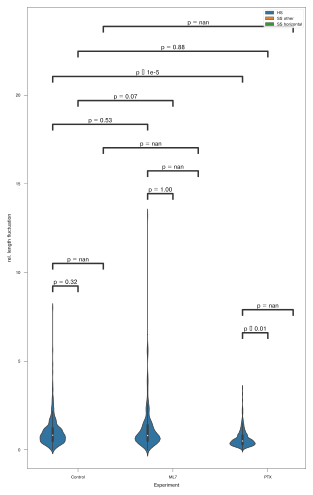

In [72]:
fix, ax = plt.subplots(1, 1, figsize=(5, 8.5))

sns.violinplot(
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_variance_norm',
    hue='class',
    hue_order=['HS', 'SS other', 'SS horizontal'],
    inner='box',
    bw=0.15
)

statannot.add_stat_annotation(
    ax,
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_variance_norm',
    hue='class__',
    hue_order=['HS', 'SS_other', 'SS_horizontal'],
    box_pairs=[
        (("Control", "HS"), ("Control", "SS_horizontal")),
        (("Control", "HS"), ("Control", "SS_other")),

        (("ML7", "HS"), ("ML7", "SS_horizontal")),
        (("ML7", "HS"), ("ML7", "SS_other")),

        (("PTX", "HS"), ("PTX", "SS_horizontal")),
        (("PTX", "HS"), ("PTX", "SS_other")),

        (("Control", "HS"), ("ML7", "HS")),
        (("Control", "SS_other"), ("ML7", "SS_other")),
        (("Control", "SS_horizontal"), ("ML7", "SS_horizontal")),

        (("Control", "HS"), ("PTX", "HS")),
        (("Control", "SS_other"), ("PTX", "SS_other")),
        (("Control", "SS_horizontal"), ("PTX", "SS_horizontal")),
    ],
    test="t-test_welch",
    text_format="simple",
    loc="inside",
)

ax.set_ylabel('rel. length fluctuation')
# ax.set_ylim([0, 2])
ax.legend(loc='upper right')


# plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation_new.svg"))

PTX_HS v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=5.795e-02
Control_HS v.s. Control_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=3.796e-08 stat=5.999e+00
ML7_HS v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.356e-01
PTX_HS v.s. PTX_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
ML7_HS v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. Control_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan


/home/julian/.local/lib/python3.10/site-packages/statannot/statannot.py:593: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.draw()


Control_SS_horizontal v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. ML7_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.271e-01
Control_SS_other v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=4.659e-06 stat=-5.134e+00
Control_HS v.s. PTX_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.534e+00
Control_SS_other v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=3.403e-11 stat=-7.124e+00
Control_SS_horizontal v.s. PTX_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan


/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


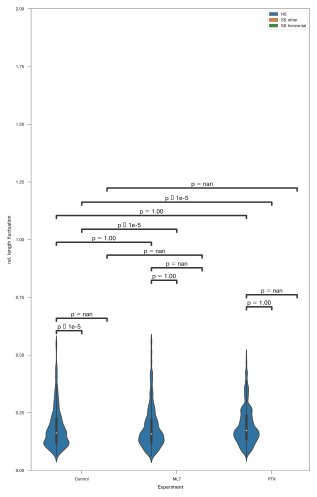

In [73]:
fix, ax = plt.subplots(1, 1, figsize=(5, 8.5))

sns.violinplot(
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_running_stddev_norm',
    hue='class',
    hue_order=['HS', 'SS other', 'SS horizontal'],
    inner='box',
    bw=0.15
)

statannot.add_stat_annotation(
    ax,
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_running_stddev_norm',
    hue='class__',
    hue_order=['HS', 'SS_other', 'SS_horizontal'],
    box_pairs=[
        (("Control", "HS"), ("Control", "SS_horizontal")),
        (("Control", "HS"), ("Control", "SS_other")),

        (("ML7", "HS"), ("ML7", "SS_horizontal")),
        (("ML7", "HS"), ("ML7", "SS_other")),

        (("PTX", "HS"), ("PTX", "SS_horizontal")),
        (("PTX", "HS"), ("PTX", "SS_other")),

        (("Control", "HS"), ("ML7", "HS")),
        (("Control", "SS_other"), ("ML7", "SS_other")),
        (("Control", "SS_horizontal"), ("ML7", "SS_horizontal")),

        (("Control", "HS"), ("PTX", "HS")),
        (("Control", "SS_other"), ("PTX", "SS_other")),
        (("Control", "SS_horizontal"), ("PTX", "SS_horizontal")),
    ],
    test="t-test_welch",
    text_format="simple",
    loc="inside",
)

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 2])
ax.legend(loc='upper right')


# plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation_new.svg"))

PTX_HS v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=5.795e-02
Control_HS v.s. Control_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=3.796e-08 stat=5.999e+00
ML7_HS v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.356e-01
PTX_HS v.s. PTX_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
ML7_HS v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. Control_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan


/home/julian/.local/lib/python3.10/site-packages/statannot/statannot.py:593: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.draw()


Control_SS_horizontal v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. ML7_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.271e-01
Control_SS_other v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=4.659e-06 stat=-5.134e+00
Control_HS v.s. PTX_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.534e+00
Control_SS_other v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=3.403e-11 stat=-7.124e+00
Control_SS_horizontal v.s. PTX_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan


/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


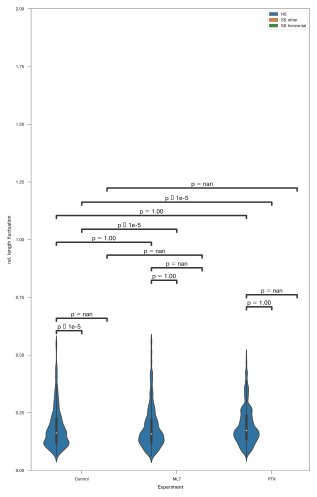

In [74]:
fix, ax = plt.subplots(1, 1, figsize=(5, 8.5))

sns.violinplot(
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_running_stddev_norm',
    hue='class',
    hue_order=['HS', 'SS other', 'SS horizontal'],
    inner='box',
    bw=0.15
)

statannot.add_stat_annotation(
    ax,
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_running_stddev_norm',
    hue='class__',
    hue_order=['HS', 'SS_other', 'SS_horizontal'],
    box_pairs=[
        (("Control", "HS"), ("Control", "SS_horizontal")),
        (("Control", "HS"), ("Control", "SS_other")),

        (("ML7", "HS"), ("ML7", "SS_horizontal")),
        (("ML7", "HS"), ("ML7", "SS_other")),

        (("PTX", "HS"), ("PTX", "SS_horizontal")),
        (("PTX", "HS"), ("PTX", "SS_other")),

        (("Control", "HS"), ("ML7", "HS")),
        (("Control", "SS_other"), ("ML7", "SS_other")),
        (("Control", "SS_horizontal"), ("ML7", "SS_horizontal")),

        (("Control", "HS"), ("PTX", "HS")),
        (("Control", "SS_other"), ("PTX", "SS_other")),
        (("Control", "SS_horizontal"), ("PTX", "SS_horizontal")),
    ],
    test="t-test_welch",
    text_format="simple",
    loc="inside",
)

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 2])
ax.legend(loc='upper right')


# plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation_new.svg"))

PTX_HS v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=5.795e-02
Control_HS v.s. Control_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=3.796e-08 stat=5.999e+00
ML7_HS v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.356e-01
PTX_HS v.s. PTX_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
ML7_HS v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. Control_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan


/home/julian/.local/lib/python3.10/site-packages/statannot/statannot.py:593: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  plt.draw()


Control_SS_horizontal v.s. ML7_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan
Control_HS v.s. ML7_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.271e-01
Control_SS_other v.s. ML7_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=4.659e-06 stat=-5.134e+00
Control_HS v.s. PTX_HS: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.534e+00
Control_SS_other v.s. PTX_SS_other: Welch's t-test independent samples with Bonferroni correction, P_val=3.403e-11 stat=-7.124e+00
Control_SS_horizontal v.s. PTX_SS_horizontal: Welch's t-test independent samples with Bonferroni correction, P_val=nan stat=nan


/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


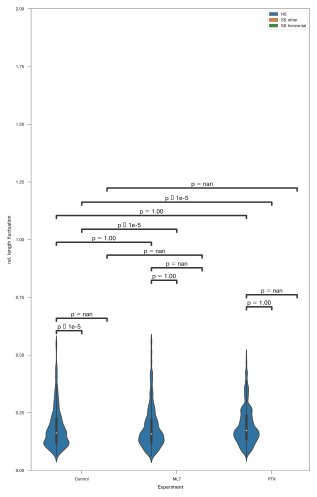

In [75]:
fix, ax = plt.subplots(1, 1, figsize=(5, 8.5))

sns.violinplot(
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_running_stddev_norm',
    hue='class',
    hue_order=['HS', 'SS other', 'SS horizontal'],
    inner='box',
    bw=0.15
)

statannot.add_stat_annotation(
    ax,
    data=tracked_bonds,
    x='Experiment',
    y='bond_length_running_stddev_norm',
    hue='class__',
    hue_order=['HS', 'SS_other', 'SS_horizontal'],
    box_pairs=[
        (("Control", "HS"), ("Control", "SS_horizontal")),
        (("Control", "HS"), ("Control", "SS_other")),

        (("ML7", "HS"), ("ML7", "SS_horizontal")),
        (("ML7", "HS"), ("ML7", "SS_other")),

        (("PTX", "HS"), ("PTX", "SS_horizontal")),
        (("PTX", "HS"), ("PTX", "SS_other")),

        (("Control", "HS"), ("ML7", "HS")),
        (("Control", "SS_other"), ("ML7", "SS_other")),
        (("Control", "SS_horizontal"), ("ML7", "SS_horizontal")),

        (("Control", "HS"), ("PTX", "HS")),
        (("Control", "SS_other"), ("PTX", "SS_other")),
        (("Control", "SS_horizontal"), ("PTX", "SS_horizontal")),
    ],
    test="t-test_welch",
    text_format="simple",
    loc="inside",
)

ax.set_ylabel('rel. length fluctuation')
ax.set_ylim([0, 2])
ax.legend(loc='upper right')


# plt.savefig("{}/{}".format(figure_path, "bond_length_fluctuation_w_orientation_new.svg"))

In [ ]:
data = tracked_bonds.loc[tracked_bonds['Experiment'] == 'Control']

sns.histplot(
    data.loc[data['type'] == 'SS'],
    x='bond_orientation_mean',
    y='bond_length_stddev_norm',
)

### Polarity

In [78]:
Experiment = 'Control'
sample_id = 2
frame = cells.loc[cells['Experiment'] == Experiment].copy()
frame = frame.loc[frame['sample_id'] == sample_id]

# overwrite cilia by available data from single frame
for track_id in np.unique(frame['track_id_cells']):
    tracked_cell = frame.loc[frame['track_id_cells'] == track_id]

    cilium = tracked_cell.loc[~np.isnan(tracked_cell['cilium_phi'])]
    if cilium.shape[0] == 0:
        continue
    if cilium.shape[0] > 1:
        raise RuntimeError("Many cilia found")

    cilium = cilium.iloc[0]

    frame.loc[frame['track_id_cells'] == track_id, 'cilium_phi'] = cilium['cilium_phi']
    frame.loc[frame['track_id_cells'] == track_id, 'cilium_phi_corrected'] = cilium['cilium_phi_corrected']
    frame.loc[frame['track_id_cells'] == track_id, 'cilium_rho'] = cilium['cilium_rho']
    frame.loc[frame['track_id_cells'] == track_id, 'cilium_rho_normalized'] = cilium['cilium_rho_normalized']
    frame.loc[frame['track_id_cells'] == track_id, 'cilium_rho_corrected'] = cilium['cilium_rho_corrected']
    frame.loc[frame['track_id_cells'] == track_id, 'cilium_DX'] = cilium['cilium_DX']
    frame.loc[frame['track_id_cells'] == track_id, 'cilium_DY'] = cilium['cilium_DY']

frame.loc[~np.isnan(frame['cilium_phi'])]

index                filename  frame_nb  local_id_cells  area_cells  \
3463     16  E10_Control_2_0000.tif         0              17         522   
3469     22  E10_Control_2_0000.tif         0              23         529   
3474     27  E10_Control_2_0000.tif         0              28         991   
3480     33  E10_Control_2_0000.tif         0              34         693   
3481     34  E10_Control_2_0000.tif         0              35         700   
...     ...                     ...       ...             ...         ...   
6523   3076  E10_Control_2_0098.tif        47              34         555   
6525   3078  E10_Control_2_0098.tif        47              36         554   
6532   3085  E10_Control_2_0098.tif        47              43         299   
6539   3092  E10_Control_2_0098.tif        47              50         600   
6540   3093  E10_Control_2_0098.tif        47              51         406   

      sum_px_intensity_cells_ch1  sum_px_intensity_cells_ch2  \
3463                           0                       20010   
3469                           0                       52156   
3474                           0                       56862   
3480                           0                       80972   
3481                           0                       27948   
...                          ...                         ...   
6523                           0                       21159   
6525                           0                       16781   
6532                           0                       22748   
6539                           0                       13999   
6540                           0                       35582   

      sum_px_intensity_cells_ch3  sum_px_intensity_cells_12_bits  \
3463                         0.0                       5122560.0   
3469                         0.0                      13351936.0   
3474                         0.0                      14556672.0   
3480                         0.0                      20728832.0   
3481                         0.0                       7154688.0   
...                          ...                             ...   
6523                       255.0                       5416959.0   
6525                       255.0                       4296191.0   
6532                       255.0                       5823743.0   
6539                         0.0                       3583744.0   
6540                       255.0                       9109247.0   

      first_pixel_x_cells  ...  cilium_rho_normalized  cilium_rho_corrected  \
3463                 42.0  ...               0.430400              0.363650   
3469                 67.0  ...               0.420658              0.332673   
3474                 85.0  ...               0.274837              0.186832   
3480                103.0  ...               0.446707              0.295548   
3481                115.0  ...               0.421670              0.273722   
...                   ...  ...                    ...                   ...   
6523                122.0  ...               0.706924              0.535300   
6525                133.0  ...               0.606194              0.265056   
6532                151.0  ...               0.446161              0.391349   
6539                187.0  ...               0.666543              0.599319   
6540                190.0  ...               0.458871              0.442991   

      cilium_phi  cilium_phi_corrected  num_cilia_cells  \
3463   -0.449239             -0.308749              NaN   
3469   -0.774313             -0.662505              NaN   
3474   -0.929369             -0.937161              NaN   
3480   -0.350536             -0.294324              NaN   
3481   -0.827863             -0.864781              NaN   
...          ...                   ...              ...   
6523   -0.873421             -0.960310              NaN   
6525   -0.238046              0.011470              NaN   
6532   -0.56823

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



/tmp/ipykernel_84137/2814288521.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS_bonds['is_close_nematic'] = np.where(


TypeError: sequence item 0: expected str instance, numpy.bool_ found

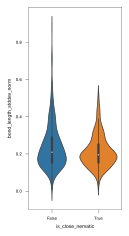

In [109]:
fix, ax = plt.subplots(1, 1, figsize=[1.7, 3.176])
plt.tight_layout()

HS_bonds['is_close_nematic'] = np.where(
    HS_bonds['cilium_angular_distance__mean'] < math.pi / 4,
    True,
    HS_bonds['cilium_angular_distance__mean'] > 3 * math.pi / 4
)

sns.violinplot(
    data=HS_bonds,
    y='bond_length_stddev_norm',
    x='is_close_nematic',
    inner='box',
    # palette=['red', 'gray'],
    # bw=0.15
)

box_pairs=[
    (False, True)
#     (("Control", "HS"), ("Control", "SS")),
#     (("ML7", "SS"), ("ML7", "HS")),
#     (("Control", "SS"), ("ML7", "SS")),
#     (("Control", "HS"), ("ML7", "HS")),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=HS_bonds,
    x='is_close_nematic',
    y='bond_length_stddev_norm',
)
annotator.configure(
    test='Mann-Whitney',
    line_width=0.75,
)
annotator.apply_and_annotate()


plt.savefig("{}/{}".format(figure_path,
                           "bond_length_fluctuation_Control_HC_angle__nematic.svg"))

### Polarity on SC-SC junction

In [ ]:
tracked_bonds.loc[tracked_bonds['type'] == 'SS']['cilium_angular_distance__mean']

                      Experiment  cilium_angular_distance__mean is_close
global_track_id_bonds                                                   
38                       Control                       2.561065    False
51                       Control                       2.782865    False
64                       Control                       2.603644    False
72                       Control                       1.792361    False
99                       Control                       2.939100    False
101                      Control                       1.984170    False
104                      Control                       1.759609    False
118                      Control                       3.133255    False
122                      Control                       1.620485    False
124                      Control                       1.795924    False
125                      Control                       1.891994    False
139                      Control                   

/tmp/ipykernel_84137/2160616064.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[~np.isnan(data['cilium_angular_distance__mean']), 'is_close'] = data.loc[~np.isnan(data['cilium_angular_distance__mean']), 'cilium_angular_distance__mean'] < np.percentile(data.loc[~np.isnan(data['cilium_angular_distance__mean']), 'cilium_angular_distance__mean'], percentil)


ValueError: `x` and `y` must be of nonzero size.

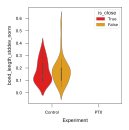

In [110]:
fix, ax = plt.subplots(1, 1, figsize=[1.7, 1.7])
plt.tight_layout()

SS_bonds = tracked_bonds.loc[tracked_bonds['type'] == 'SS']
mask = np.where(
    SS_bonds['Experiment'] == 'Control',
    True,
    SS_bonds['Experiment'] == 'PTX',
)
data = SS_bonds.loc[mask]

percentil = 30
# data.loc[~np.isnan(data['cilium_rho__mean']), 'is_close'] = data.loc[~np.isnan(data['cilium_rho__mean']), 'cilium_rho__mean'] < np.percentile(data.loc[~np.isnan(data['cilium_rho__mean']), 'cilium_rho__mean'], percentil)
data.loc[~np.isnan(data['cilium_angular_distance__mean']), 'is_close'] = data.loc[~np.isnan(data['cilium_angular_distance__mean']), 'cilium_angular_distance__mean'] < np.percentile(data.loc[~np.isnan(data['cilium_angular_distance__mean']), 'cilium_angular_distance__mean'], percentil)
# data['is_close'] = data['cilium_angular_distance__mean'] < math.pi / 2

print(data.loc[data['cilium_angular_distance__mean'] > math.pi / 2, ['Experiment', 'cilium_angular_distance__mean', 'is_close']])

sns.violinplot(
    data=data,
    x='Experiment', order=['Control', 'PTX'],
    y='bond_length_stddev_norm',
    hue='is_close', hue_order=[True, False],
    inner='box',
    palette=['red', 'orange'],
    linewidth=linewidth,
)

box_pairs=[
    (("Control", True), ("Control", False)),
    (("PTX", True), ("PTX", False)),
    (("Control", True), ("PTX", True)),
    (("Control", False), ("PTX", False)),
]

annotator = Annotator(
    ax,
    box_pairs,
    data=data,
    x='Experiment', order=['Control', 'PTX'],
    y='bond_length_stddev_norm',
    hue='is_close', hue_order=[True, False],
)
annotator.configure(
    test='Mann-Whitney',
    line_width=linewidth,
)
annotator.apply_and_annotate()


ax.set_ylabel('rel. length fluctuation')
# ax.set_xlabel('Angle to cilium')
ax.set_ylim([0, 1.])
# ax.set_xticklabels([r'$<\dfrac{\pi}{2}$',r'$\geq\dfrac{\pi}{2}$'])
ax.set_yticks([0., 0.5, 1.])
# ax.legend(loc='upper right')

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, [r'$<90\degree$', r'$\geq90\degree$'], title='SC-SC circular distance', loc='upper left', bbox_to_anchor=(1,1.025))



# mpl.pyplot.legend(bbox_to_anchor=(1,1.025))

In [ ]:
sns.histplot(
    data=data,
    x='cilium_angular_distance__mean',
    hue='is_close',
    # binrange=[0, 30],
    multiple='stack',
)

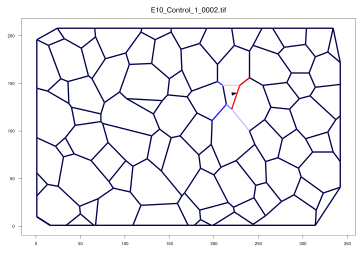

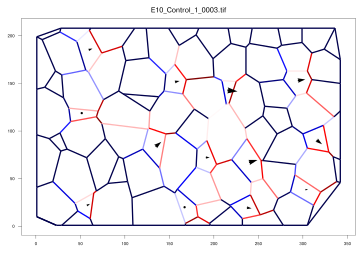

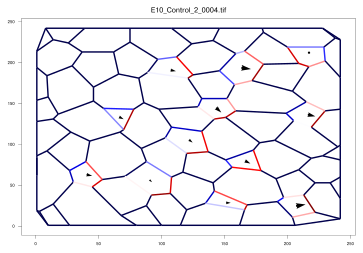

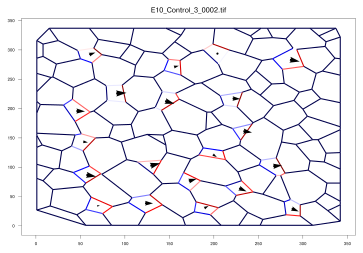

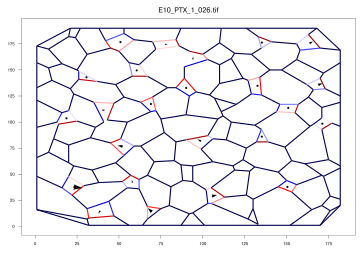

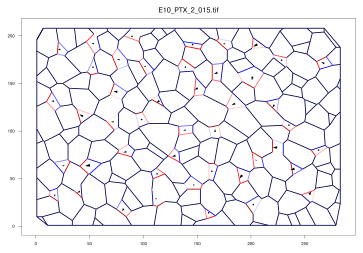

In [111]:
for frame in np.unique(bonds.loc[~np.isnan(bonds['cilium_angular_distance']), 'filename']):
    frame_bonds = bonds.loc[bonds['filename']==frame]
    fig, ax = plt.subplots(1, 1)
    # color = np.where(frame_bonds['type'] == 'SS', 'gray', 'black')
    # color = np.where(frame_bonds['type'] == 'HS', 'orange', color)
    # color = np.where(frame_bonds['type'] == 'HH', 'red', color)
    # color = np.where(frame_bonds['type'] == 'border', 'skyblue', color)
    # color = np.where(frame_bonds['type'] == 'border_plus_one',
    #                 'deepskyblue',
    #                 color)
    color=np.where(
        ~np.isnan(frame_bonds['cilium_angular_distance']),
        frame_bonds['cilium_angular_distance'],
        0
    )
    ax.quiver(
        frame_bonds['vx_1_x'],
        frame_bonds['vx_1_y'],
        frame_bonds['vx_2_x'] - frame_bonds['vx_1_x'],
        frame_bonds['vx_2_y'] - frame_bonds['vx_1_y'],
        color,
        cmap='seismic',
        clim=[0, math.pi],
        # vmin=0,
        # vmax=math.pi,
        scale_units='xy', angles='xy', scale=1,
        headwidth=0, headlength=0,headaxislength=0,
    )

    frame_cells = cells.loc[cells['filename']==frame]
    rho = (frame_cells['area_cells']/ math.pi)**0.5
    ax.quiver(
        frame_cells['center_x_cells'],
        frame_cells['center_y_cells'],
        rho * frame_cells['cilium_rho_corrected'] * np.cos(frame_cells['cilium_phi_corrected']),
        rho * frame_cells['cilium_rho_corrected'] * np.sin(frame_cells['cilium_phi_corrected']),
        color='black',
        scale_units='xy', angles='xy', scale=1,
    )

    ax.set_title(frame)

### Temporal development

<AxesSubplot:xlabel='time', ylabel='bond_length_in_px'>

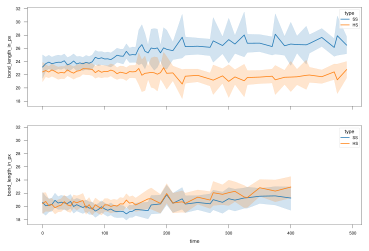

In [116]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

sns.lineplot(
    data=bonds.loc[bonds['Experiment'] == 'Control'],
    x='time',
    y='bond_length_in_px',
    hue='type',
    hue_order=['SS', 'HS'],
    ax=ax1
)

sns.lineplot(
    data=bonds.loc[bonds['Experiment'] == 'ML7'],
    x='time',
    y='bond_length_in_px',
    hue='type',
    hue_order=['SS', 'HS'],
    ax=ax2
)

# g = sns.FacetGrid(tracked_bonds,
#                   col="data",
#                   row="Experiment",
#                   hue='type', margin_titles=True,
#                   sharey="col", sharex=True)
# g.map_dataframe(sns.lineplot, x="time", y="data_values",
#       markers=True, ci='sd', err_style='band')
# # g = g.map(lambda **kw: plt.axhline(0., color="black", ls=":"))

# g.set_ylabels("Rel. change")
# g.set_xlabels("Time [{}]".format(time_step_units))

## Summary

In [117]:
cells['area_change_rate'] = np.nan
def difference(cell, *, cells):
      if (cell['frame'] == 0):
            return np.nan
      
      ref = cells.loc[cells['frame'] == (cell['frame'] - 1)]
      ref = ref.loc[ref['track_id_cells'] == cell['track_id_cells']]
      if ref.shape[0] == 0:
            ref = cells.loc[cells['frame'] == (cell['frame'] - 5)]

            ref = ref.loc[ref['track_id_cells'] == cell['track_id_cells']]
            if ref.shape[0] == 0:
                  return np.nan

      ref = ref.iloc[0]

      delta = (cell['area_cells'] - ref['area_cells']) / abs(cell['area_cells'])
      delta /= cell['time'] - ref['time']

      return np.abs(delta)
cells['area_change_rate'] = cells.apply(difference, axis=1, cells=cells)

In [ ]:
def difference(bond, *, bonds):
      if (bond['frame'] == 0):
            return np.nan
      
      ref = bonds.loc[bonds['frame_nb'] == (bond['frame_nb'] - 1)]
      ref = ref.loc[ref['track_id_bonds'] == bond['track_id_bonds']]
      if ref.shape[0] == 0:
            return np.nan

      ref = ref.iloc[0]

      delta = bond['bond_length_in_px'] - ref['bond_length_in_px']
      delta /= bond['time'] - ref['time']
      delta /= np.abs(bond['bond_length_in_px'])

      return np.abs(delta)
bonds['length_change_rate'] = bonds.apply(difference, axis=1, bonds=bonds)

In [ ]:
g = sns.FacetGrid(cells, col="data", row="Experiment",
                  hue='is_HC', 
                  margin_titles=True,
                  sharey="col", sharex=True)
g.map_dataframe(sns.lineplot, x="time", y="data_values",
                size='sample_id',
                markers=True, ci='sd', err_style='band', )
# g = g.map(lambda **kw: plt.axhline(0., color="black", ls=":"))

g.set_ylabels("Rel. change")
g.set_xlabels("Time [{}]".format(time_step_units))
g.add_legend()

plt.savefig("{}/../{}.svg".format(path[0], "summary_change"))

In [ ]:
rel_length = bonds.loc[bonds['bond_rel_length_change_in_px'] < 1]
rel_length['object_type'] = 'bond'
rel_length['data'] = 'length_change'
rel_length['data_hue'] = bonds['type']
rel_length['data_id'] = bonds['track_id_bonds']
rel_length['data_values'] = rel_length['bond_rel_length_change_in_px']
rel_length = rel_length.dropna(subset=['data_values'])
rel_length = rel_length.loc[rel_length['type'] != 'border_plus_one']
rel_length = rel_length.loc[rel_length['type'] != 'HH']

bond_length = _bonds#.loc[bonds['bond_rel_length_change_in_px'] < 1]
bond_length['object_type'] = 'bond'
bond_length['data'] = 'bond_length'
bond_length['data_hue'] = bonds['type']
bond_length['data_id'] = bonds['track_id_bonds']
bond_length['data_values'] = bond_length['bond_length_in_px']
bond_length = bond_length.dropna(subset=['data_values'])
bond_length = bond_length.loc[bond_length['type'] != 'border_plus_one']
bond_length = bond_length.loc[bond_length['type'] != 'HH']


bond_rate = _bonds#.loc[bonds['bond_rel_length_change_in_px'] < 1]
# bond_rate = bonds.loc[bonds['frame'] < 60]
bond_rate['object_type'] = 'bond'
bond_rate['data'] = 'length_change_rate'
bond_rate['data_hue'] = bonds['type']
bond_rate['data_id'] = bonds['track_id_bonds']
bond_rate['data_values'] = bonds['length_change_rate']
bond_rate = bond_rate.dropna(subset=['data_values'])
bond_rate = bond_rate.loc[bond_rate['type'] != 'border_plus_one']
bond_rate = bond_rate.loc[bond_rate['type'] != 'HH']




rel_area = cells
rel_area['object_type'] = 'cell'
rel_area['data'] = 'area_change'
rel_area['data_hue'] = np.where(cells['is_HC'], 'H', 'S')
rel_area['data_id'] = cells['track_id_cells']
rel_area['data_values'] = rel_area['area_rel_change_cells']
rel_area = rel_area.dropna(subset=['data_values'])

cell_area = cells
cell_area['object_type'] = 'cell'
cell_area['data'] = 'cell_area'
cell_area['data_hue'] = np.where(cells['is_HC'], 'H', 'S')
cell_area['data_id'] = cells['track_id_cells']
cell_area['data_values'] = cell_area['area_cells']
cell_area = cell_area.dropna(subset=['data_values'])

cell_norm_area = cells
cell_norm_area['object_type'] = 'cell'
cell_norm_area['data'] = 'cell_norm_area'
cell_norm_area['data_hue'] = np.where(cells['is_HC'], 'H', 'S')
cell_norm_area['data_id'] = cells['track_id_cells']
cell_norm_area['data_values'] = cell_norm_area['normalized_area_cells']
cell_norm_area = cell_norm_area.dropna(subset=['data_values'])

cell_rate = cells
cell_rate['object_type'] = 'cell'
cell_rate['data'] = 'area_change_rate'
cell_rate['data_hue'] = np.where(cells['is_HC'], 'H', 'S')
cell_rate['data_id'] = cells['track_id_cells']
cell_rate['data_values'] = cells['area_change_rate']
cell_rate = cell_rate.dropna(subset=['data_values'])
print(cell_rate)

neighbors = cells
neighbors['object_type'] = 'cell'
neighbors['data'] = 'num_neighbors'
neighbors['data_hue'] = np.where(cells['is_HC'], 'H', 'S')
neighbors['data_values'] = neighbors['num_neighbors']
neighbors = neighbors.dropna(subset=['data_values'])




data = rel_length
data = data.append(bond_length)
# data = data.append(bond_rate)
data = data.append(rel_area)
data = data.append(cell_area)
data = data.append(cell_norm_area)
# data = data.append(cell_rate)
data = data.append(neighbors)

data = data.dropna(subset=['data_values'])

g = sns.FacetGrid(data, col="data", row="Experiment",
                  hue='data_hue', hue_order=['S', 'H'],
                  col_order=['cell_norm_area', 'cell_area', 'area_change', 'area_change_rate', 'num_neighbors'],
                  margin_titles=True,
                  sharey="col", sharex=True)
g.map_dataframe(sns.lineplot, x="time", y="data_values",
                size='sample_id',
                markers=True, ci='sd', err_style='band', )
# g = g.map(lambda **kw: plt.axhline(0., color="black", ls=":"))

g.set_xlabels("Time [{}]".format(time_step_units))
g.add_legend()

plt.savefig("{}/../{}.svg".format(path[0], "summary_change_cells"))

g = sns.FacetGrid(data, col="data", row="Experiment",
                  hue='data_hue', hue_order=['SS', 'HS'],
                  col_order=['bond_length', 'length_change', 'length_change_rate'],
                  margin_titles=True,
                  sharey="col", sharex=True)
g.map_dataframe(sns.lineplot, x="time", y="data_values",
                size='sample_id',
                markers=True, ci='sd', err_style='band', )
# g = g.map(lambda **kw: plt.axhline(0., color="black", ls=":"))

g.set_xlabels("Time [{}]".format(time_step_units))
g.add_legend()

plt.savefig("{}/../{}.svg".format(path[0], "summary_change_bonds"))

In [ ]:
foo = cells.groupby(by='Experiment').apply(lambda cells: print(cells.groupby(by='global_id_cells')))

In [ ]:

print('absolute length change rate')
_bond_rate = bond_rate.loc[bond_rate['frame'] <= 30]
control = _bond_rate.loc[_bond_rate['Experiment'] == "Control"]
ml7 = _bond_rate.loc[_bond_rate['Experiment'] == "ML7"]
print("SC Rate changes control : {:.2f}+-{:.2f}".format(control.loc[control['type'] == 'SS']['data_values'].mean(), control.loc[control['type'] == 'SS']['data_values'].std()))
print("SC Rate changes ML-7 : {:.2f}+-{:.2f}".format(ml7.loc[ml7['type'] == 'SS']['data_values'].mean(), ml7.loc[ml7['type'] == 'SS']['data_values'].std()))

print("HC Rate changes control : {:.2f}+-{:.2f}".format(control.loc[control['type'] == 'HS']['data_values'].mean(), control.loc[control['type'] == 'HS']['data_values'].std()))
print("HC Rate changes ML-7 : {:.2f}+-{:.2f}".format(ml7.loc[ml7['type'] == 'HS']['data_values'].mean(), ml7.loc[ml7['type'] == 'HS']['data_values'].std()))

print('relative changes')
_bond_rate = bond_rel_rate.loc[bond_rel_rate['frame'] <= 30]
control = _bond_rate.loc[_bond_rate['Experiment'] == "Control"]
ml7 = _bond_rate.loc[_bond_rate['Experiment'] == "ML7"]
print("SC Rate changes control : {:.5f}+-{:.5f}".format(control.loc[control['type'] == 'SS']['data_values'].mean(), control.loc[control['type'] == 'SS']['data_values'].std()))
print("SC Rate changes ML-7 : {:.5f}+-{:.5f}".format(ml7.loc[ml7['type'] == 'SS']['data_values'].mean(), ml7.loc[ml7['type'] == 'SS']['data_values'].std()))

print("HC Rate changes control : {:.5f}+-{:.5f}".format(control.loc[control['type'] == 'HS']['data_values'].mean(), control.loc[control['type'] == 'HS']['data_values'].std()))
print("HC Rate changes ML-7 : {:.5f}+-{:.5f}".format(ml7.loc[ml7['type'] == 'HS']['data_values'].mean(), ml7.loc[ml7['type'] == 'HS']['data_values'].std()))


print("Variance")
def variance(bond):
    if bond.shape[0] < 10:
        return np.nan
    return bond['bond_length_in_px'].std() / bond['bond_length_in_px'].mean()
variance = pd.Series(bonds.groupby(by='track_id_bonds').apply(variance), name='variance').to_frame()
variance['type'] = bonds.groupby(by='track_id_bonds').apply(lambda bond: bond.iloc[0]['type'])
variance['Experiment'] = bonds.groupby(by='track_id_bonds').apply(lambda bond: bond.iloc[0]['Experiment'])
variance['sample_id'] = bonds.groupby(by='track_id_bonds').apply(lambda bond: bond.iloc[0]['sample_id'])


In [ ]:

g = sns.FacetGrid(variance, row="Experiment",
                  hue="type", hue_order=['SS', 'HS'],
                  margin_titles=True, aspect=5)

g.map_dataframe(sns.histplot, x="variance", binrange=[0, 1.], bins=20,
                stat='probability', common_norm=False, common_bins=True)
g.add_legend()

control = variance[variance['Experiment'] == 'Control']
print('Mean variance SS {} +- {}'.format(
    control[control['type'] == 'SS']['variance'].mean(),
    control[control['type'] == 'SS']['variance'].std()
))
print('Mean variance HS {} +- {}'.format(
    control[control['type'] == 'HS']['variance'].mean(),
    control[control['type'] == 'HS']['variance'].std()
))

print('Median variance SS {}'.format(
    control[control['type'] == 'SS']['variance'].median()
))
print('Median variance HS {}'.format(
    control[control['type'] == 'HS']['variance'].median()
))


print('ML7')
ml7 = variance[variance['Experiment'] == 'ML7']
print('Mean variance SS {} +- {}'.format(
    ml7[ml7['type'] == 'SS']['variance'].mean(),
    ml7[ml7['type'] == 'SS']['variance'].std()
))
print('Mean variance HS {} +- {}'.format(
    ml7[ml7['type'] == 'HS']['variance'].mean(),
    ml7[ml7['type'] == 'HS']['variance'].std()
))

print('Median variance SS {}'.format(
    ml7[ml7['type'] == 'SS']['variance'].median()
))
print('Median variance HS {}'.format(
    ml7[ml7['type'] == 'HS']['variance'].median()
))


In [ ]:
_bond_rate = bond_rel_rate#.loc[bond_rel_rate['frame'] <= 30]
_bond_rate = _bond_rate.loc[_bond_rate['data_values'] > 1.e-8]

g = sns.FacetGrid(_bond_rate, row="Experiment", hue="type",
                  margin_titles=True, aspect=5)

g.map_dataframe(sns.histplot, x="data_values", binrange=[0, 0.1], bins=100,
                stat='probability', common_norm=False)
g.add_legend()

In [ ]:

g = sns.FacetGrid(data, col="data", row="Experiment",
                  hue='data_id', margin_titles=True,
                  sharey="col", sharex=True)
g.map_dataframe(sns.lineplot, x="time", y="data_values",
      markers=True, ci='sd', err_style='band')
# g = g.map(lambda **kw: plt.axhline(0., color="black", ls=":"))

g.set_ylabels("Rel. change")
g.set_xlabels("Time [{}]".format(time_step_units))

In [ ]:
print("N Cells:")
print(cells.loc[cells['time'] == 0].groupby(by='Experiment')[['time', 'track_id_cells']].count())
print(cells.loc[cells['time'] == 120].groupby(by='Experiment')[['time', 'track_id_cells']].count())
print(cells.loc[cells['time'] == 180].groupby(by='Experiment')[['time', 'track_id_cells']].count())
print(cells.loc[cells['time'] == 240].groupby(by='Experiment')[['time', 'track_id_cells']].count())
print(cells.loc[cells['time'] == 300].groupby(by='Experiment')[['time', 'track_id_cells']].count())
print(cells.loc[cells['time'] == 400].groupby(by='Experiment')[['time', 'track_id_cells']].count())

print("\n\nN Bonds:")
print(bonds.loc[bonds['time'] == 0].groupby(by='Experiment')[['time', 'track_id_bonds']].count())
print(bonds.loc[bonds['time'] == 120].groupby(by='Experiment')[['time', 'track_id_bonds']].count())
print(bonds.loc[bonds['time'] == 180].groupby(by='Experiment')[['time', 'track_id_bonds']].count())
print(bonds.loc[bonds['time'] == 240].groupby(by='Experiment')[['time', 'track_id_bonds']].count())
print(bonds.loc[bonds['time'] == 300].groupby(by='Experiment')[['time', 'track_id_bonds']].count())
print(bonds.loc[bonds['time'] == 400].groupby(by='Experiment')[['time', 'track_id_bonds']].count())

In [ ]:
# g = sns.FacetGrid(bonds, col="data", row="type",
#                   hue='track_id_bonds', margin_titles=True)
# g.map_dataframe(sns.lineplot, x="time", y="bond_rel_length_change_in_px",
#       markers=True, ci='sd', err_style='band')
# g = g.map(lambda **kw: plt.axhline(0., color="black", ls=":"))

# g.set_ylabels("Rel. change")
# g.set_xlabels("Time [{}]".format(time_step_units))
# # g.add_legend()

In [ ]:
g = sns.FacetGrid(cells, col="data", row="is_HC",
                  hue='track_id_cells', margin_titles=True)
g.map_dataframe(sns.lineplot, x="time", y="area_rel_change_cells",
      markers=True, ci='sd', err_style='band')
g = g.map(lambda **kw: plt.axhline(0., color="black", ls=":"))

g.set_ylabels("Rel. change")
g.set_xlabels("Time [{}]".format(time_step_units))
# g.add_legend()

In [ ]:
bulk_bonds = bonds[bonds['type'] != 'border_plus_one'].dropna(how='all')
normalization_length = bulk_bonds.groupby(
    by=['filename'])['bond_length_in_px'].mean()
bonds['normalized_bond_length'] = bonds.apply(
    lambda b, *, normalization:
        b['bond_length_in_px'] / normalization[b['filename']],
    normalization=normalization_length, axis=1)

In [ ]:
rel_length = bonds
rel_length['object_type'] = 'bond'
rel_length['data'] = 'norm_bond_length'
rel_length['data_hue'] = bonds['type']
rel_length['data_values'] = rel_length['normalized_bond_length']
rel_length = rel_length.dropna(subset=['data_values'])
rel_length = rel_length.loc[rel_length['type'] != 'border_plus_one']
rel_length = rel_length.loc[rel_length['type'] != 'HH']

rel_length_HH = rel_length.loc[rel_length['type'] == 'HS']
rel_length_SS = rel_length.loc[rel_length['type'] == 'SS']

rel_length_HH = rel_length_HH.loc[rel_length_HH.apply(lambda x: (x['time'] == 10 or x['time'] == 60 or x['time'] == 150), axis=1)]
rel_length_SS = rel_length_SS.loc[rel_length_SS.apply(lambda x: x['time'] == 10 or x['time'] == 60 or x['time'] == 150, axis=1)]

rel_area = cells
rel_area['object_type'] = 'cell'
rel_area['data'] = 'norm_cell_area'
rel_area['data_hue'] = cells.apply(lambda cell: 'H' if cell['is_HC'] else 'S', axis=1)
rel_area['data_values'] = rel_area['normalized_area_cells']
rel_area = rel_area.dropna(subset=['data_values'])

rel_area_H = rel_area.loc[rel_area['is_HC']]
rel_area_S = rel_area.loc[~rel_area['is_HC']]
rel_area_H = rel_area_H.loc[rel_area_H.apply(lambda x: x['time'] == 10 or x['time'] == 60 or x['time'] == 150, axis=1)]
rel_area_S = rel_area_S.loc[rel_area_S.apply(lambda x: x['time'] == 10 or x['time'] == 60 or x['time'] == 150, axis=1)]


data_H = pd.concat([rel_length_HH, rel_area_H], axis=0, ignore_index=True)
data_S = pd.concat([rel_length_SS, rel_area_S], axis=0, ignore_index=True)

def histplot(*args, **kwargs):
    return sns.histplot(*args, multiple="dodge", **kwargs)


g = sns.FacetGrid(data_H, col="data", row="Experiment",
                  hue='time', margin_titles=True)
g.map_dataframe(histplot, x="data_values")

# g.set_ylabels("Rel. change")
# g.set_xlabels("Time [{}]".format(time_step_units))
g.add_legend()
g.set_titles("Hair cells")
plt.savefig("{}/../{}.svg".format(path[0], "summary_stats_HC"))


g = sns.FacetGrid(data_S, col="data", row="Experiment",
                  hue='time', margin_titles=True)
g.map_dataframe(histplot, x="data_values")

# g.set_ylabels("Rel. change")
# g.set_xlabels("Time [{}]".format(time_step_units))
g.add_legend()
g.set_titles("Support cells")

plt.savefig("{}/../{}.svg".format(path[0], "summary_stats_SC"))

## polarity

In [ ]:
bonds['mid_x'] = (bonds['vx_1_x'] + bonds['vx_2_x']) / 2.
bonds['mid_y'] = (bonds['vx_1_y'] + bonds['vx_2_y']) / 2.

In [ ]:
ss_bonds = bonds.loc[bonds['type'] == 'SS']

In [ ]:
n1_bonds = bonds['global_cell_id_around_bond1']

## Available sets

In [ ]:
print("Available datasets: ")
for set in cells.columns:
  print("  {}".format(set))

In [ ]:
print("Available datasets in bonds: ")
for set in bonds.columns:
  print("  {}".format(set))

In [ ]:
print(HC['hair_neighbors'])

In [ ]:
print(cells['HC_normalized_area'].mean())
print(HC['num_neighbors'].mean())
print(SC['num_neighbors'].mean())
print(cells['num_neighbors'].mean())
print(HC['num_hair_neighbors'].mean())
